<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Clustering: Mice Protein Expression
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b> Third homework - 28/06/2022<br>
    </div>
    </td>
</tr>
</table>

With this analysis I want to use the most common clustering methods to divide these mice in 8 different groups according to gene expression and 3 different categorical variables.

#### The output classes expected are:
c-CS-s: control mice, stimulated to learn, injected with saline 

c-CS-m: control mice, stimulated to learn, injected with memantine 

c-SC-s: control mice, not stimulated to learn, injected with saline 

c-SC-m: control mice, not stimulated to learn, injected with memantine 

t-CS-s: trisomy mice, stimulated to learn, injected with saline 

t-CS-m: trisomy mice, stimulated to learn, injected with memantine 

t-SC-s: trisomy mice, not stimulated to learn, injected with saline 

t-SC-m: trisomy mice, not stimulated to learn, injected with memantine

### Disclaimer!
The analyses that I did here had as task to observe the different behaviour of the common clusterization models that I used during the course in addition to some models related to them, not covered during lecture, that I found of interest for this purpose. 
For this reason I decided to keep all the suitable features (including genotype, treatment and behavior and excluding all columns with too many missing values) to test if the methods that I learnt were able to cluster my samples in the original 8 classes. More interesting analyses of this dataset, that I didn't cover, are related to the use of clustering methods to discover a new way, using only gene expression features, to find relations between the samples outside the already known classes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import fowlkes_mallows_score as fms
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.model_selection import GridSearchCV

import random
np.random.seed(0)

In [2]:
def plot3d(X, labels):
    %matplotlib inline
    from mpl_toolkits.mplot3d import Axes3D
    
    pca = TSNE(n_components=3)
    
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    col = ('tab10' if nlabels <= 10 else 
          ('tab20' if nlabels <= 20 else
           'hsv'))
    cmap = plt.cm.get_cmap(col)
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=labels, cmap=cmap)
    plt.colorbar(mappable=smap, label='digit label', ticks=range(nlabels))

In [3]:
def interactive_plot3d(X, labels):
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    
    pca = TSNE(n_components=3)

    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    col = ('tab10' if nlabels <= 10 else 
          ('tab20' if nlabels <= 20 else
           'hsv'))
    cmap = plt.cm.get_cmap(col)
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)

    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=labels, cmap=cmap)
    plt.colorbar(mappable=smap, label='digit label', ticks=range(nlabels))

In [4]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)
    
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ddata = dendrogram(Z, ax=ax, **kwargs)
    
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax

In [5]:
def get_node_leaves(Z, idx, N):
    n1, n2 = int(Z[idx,0]), int(Z[idx,1])
    leaves = []
    for n in [n1, n2]:
        if n < N:
            leaves += [n]
        else:
            leaves += get_node_leaves(Z, n-N, N)
    return leaves

def plot_node(Z, X, y, idx, maxn=15*15):
    leaves = get_node_leaves(Z, idx, X.shape[0])
    labels, counts = np.unique(y[leaves], return_counts=True)
    nleaves = len(leaves)
    print(pd.DataFrame(np.array(counts).reshape(1,-1), 
                       columns=labels, index=["Frequency:"]))
    print("Images in the cluster:", len(leaves), "/", X.shape[0])

    random.shuffle(leaves)
    leaves = leaves[:maxn]
    h = min((nleaves // 15)+1, 15)
    w = nleaves if nleaves < 15 else 15
    
    fig, axes = plt.subplots(h, w, figsize=(w, h),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        if i < nleaves:
            ax.imshow(X[leaves[i]], cmap='binary', interpolation='nearest')
            ax.text(0.05, 0.05, str(y[leaves[i]]), transform=ax.transAxes, color='r')
        else:
            ax.set_axis_off()

In [6]:
def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]
    
    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)
        xx, yy = np.meshgrid(sample_idx, sample_idx)
        mat[xx, yy] = 1
        
    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()
    
    sim_mat = 1 - (dist_mat - min_dist) / (max_dist - min_dist)
    return sim_mat

def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    
    inc = normalize(inc.reshape(1, -1))
    sim = normalize(sim.reshape(1, -1))
    corr = inc @ sim.T
    
    return corr[0,0]   

In [7]:
def sorted_mat(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    sim = sim[idx_sorted,:]
    sim = sim[:, idx_sorted]
    
    return sim

def plot_sorted_mat(sim, y_pred):
    sim = sorted_mat(sim, y_pred)
    
    fig, ax = plt.subplots(figsize=(40,30))  
    ax = sns.heatmap(sim, ax=ax)
    ax.set_yticks([]) 
    ax.set_xticks([])

In [8]:
def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj
def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)
    
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def tot_recall(y_predict, y_true):
     r = recall(y_predict, y_true, k, j)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

In [9]:
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y)
    return scorer

## Preprocessing: data preparation

Checking the datasest:
it has 1080 rows and 82 columns

In [10]:
df = pd.read_excel('Data_Cortex_Nuclear.xls')
df

MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0        309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1        309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2        309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3        309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4        309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   
...        ...       ...       ...       ...       ...       ...       ...   
1075  J3295_11  0.254860  0.463591  0.254860  2.092082  2.600035  0.211736   
1076  J3295_12  0.272198  0.474163  0.251638  2.161390  2.801492  0.251274   
1077  J3295_13  0.228700  0.395179  0.234118  1.733184  2.220852  0.220665   
1078  J3295_14  0.221242  0.412894  0.243974  1.876347  2.384088  0.208897   
1079  J3295_15  0.302626  0.461059  0.256564  2.092790  2.594348  0.251001   

       pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0     0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1     0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2     0.175722   2.283337  0.230247  ...  0.106219  0.435777   0.111883   
3     0.176463   2.152301  0.207004  ...  0.111262  0.391691   0.130405   
4     0.173627   2.134014  0.192158  ...  0.110694  0.434154   0.118481   
...        ...        ...       ...  ...       ...       ...        ...   
1075  0.171262   2.483740  0.207317  ...  0.183324  0.374088   0.318782   
1076  0.182496   2.512737  0.216339  ...  0.175674  0.375259   0.325639   
1077  0.161435   1.989723  0.185164  ...  0.158296  0.422121   0.321306   
1078  0.173623   2.086028  0.192044  ...  0.196296  0.397676   0.335936   
1079  0.191811   2.361816  0.223632  ...  0.187556  0.420347   0.335062   

        EGR1_N  H3MeK4_N    CaNA_N  Genotype  Treatment  Behavior   class  
0     0.131790  0.128186  1.675652   Control  Memantine       C/S  c-CS-m  
1     0.135103  0.131119  1.743610   Control  Memantine       C/S  c-CS-m  
2     0.133362  0.127431  1.926427   Control  Memantine       C/S  c-CS-m  
3     0.147444  0.146901  1.700563   Control  Memantine       C/S  c-CS-m  
4     0.140314  0.148380  1.839730   Control  Memantine       C/S  c-CS-m  
...        ...       ...       ...       ...        ...       ...     ...  
1075  0.204660  0.328327  1.364823    Ts65Dn     Saline       S/C  t-SC-s  
1076  0.200415  0.293435  1.364478    Ts65Dn     Saline       S/C  t-SC-s  
1077  0.229193  0.355213  1.430825    Ts65Dn     Saline       S/C  t-SC-s  
1078  0.251317  0.365353  1.404031    Ts65Dn     Saline       S/C  t-SC-s  
1079  0.252995  0.365278  1.370999    Ts65Dn     Saline       S/C  t-SC-s  

[1080 rows x 82 columns]

#### checking features data type

In [11]:
pd.DataFrame(df.dtypes, columns = ["Data Type"]) 

Data Type
MouseID      object
DYRK1A_N    float64
ITSN1_N     float64
BDNF_N      float64
NR1_N       float64
...             ...
CaNA_N      float64
Genotype     object
Treatment    object
Behavior     object
class        object

[82 rows x 1 columns]

Dropping 'MouseID' column because I don't need it for this task

In [12]:
df = df.drop('MouseID', axis = 1)

#### Checking NULL values:
There are quite a lot Null/missing values to directly drop all this rows, so I adopted a combination of method to keep as many data as possible and remove all entries with too many missing values

In [13]:
df.isna().sum().sum()

1396

First I remove three samples with the majority of null values

In [14]:
df = df.drop([987,988,989])

Then for each columns I check which of them has more than the 10% of the data as NULL values and I drop them

In [15]:
df = df.dropna(how='any',axis=1,thresh=df.shape[0]*0.9)

In the end I reset the entries ID and fill the missing values with the mean of the values for each feature

In [16]:
df = df.reset_index(drop=True)

In [17]:
df = df.fillna(df.mean())

C:\Users\giuli\AppData\Local\Temp\ipykernel_5856\114435927.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


Encoding of the three categorical features and the target 'class' feature

In [18]:
df['Genotype'] = df['Genotype'].replace({'Control': 0, 'Ts65Dn': 1})

In [19]:
df['Treatment'] = df['Treatment'].replace({'Memantine': 0, 'Saline': 1})

In [20]:
df['Behavior'] = df['Behavior'].replace({'C/S': 0, 'S/C': 1})

In [21]:
df['class'] = df['class'].replace({"c-CS-m": 0, "c-SC-m": 1, 'c-CS-s': 2, 'c-SC-s': 3, 't-CS-m':4, 't-SC-m':5, 't-SC-s':6, 't-CS-s':7})

In [22]:
df

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0     0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
1     0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
2     0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
3     0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4     0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
...        ...       ...       ...       ...       ...       ...       ...   
1072  0.254860  0.463591  0.254860  2.092082  2.600035  0.211736  0.171262   
1073  0.272198  0.474163  0.251638  2.161390  2.801492  0.251274  0.182496   
1074  0.228700  0.395179  0.234118  1.733184  2.220852  0.220665  0.161435   
1075  0.221242  0.412894  0.243974  1.876347  2.384088  0.208897  0.173623   
1076  0.302626  0.461059  0.256564  2.092790  2.594348  0.251001  0.191811   

      pCAMKII_N   pCREB_N    pELK_N  ...  pGSK3B_Tyr216_N     SHH_N     pS6_N  \
0      2.373744  0.232224  1.750936  ...         0.831557  0.188852  0.106305   
1      2.292150  0.226972  1.596377  ...         0.849270  0.200404  0.106592   
2      2.283337  0.230247  1.561316  ...         0.846709  0.193685  0.108303   
3      2.152301  0.207004  1.595086  ...         0.833277  0.192112  0.103184   
4      2.134014  0.192158  1.504230  ...         0.878668  0.205604  0.104784   
...         ...       ...       ...  ...              ...       ...       ...   
1072   2.483740  0.207317  1.057971  ...         0.962942  0.275547  0.115806   
1073   2.512737  0.216339  1.081150  ...         0.983690  0.283207  0.113614   
1074   1.989723  0.185164  0.884342  ...         0.976609  0.290843  0.118948   
1075   2.086028  0.192044  0.922595  ...         0.989286  0.306701  0.125295   
1076   2.361816  0.223632  1.064085  ...         1.020383  0.292330  0.118899   

       pCFOS_N     SYP_N    CaNA_N  Genotype  Treatment  Behavior  class  
0     0.108336  0.427099  1.675652         0          0         0      0  
1     0.104315  0.441581  1.743610         0          0         0      0  
2     0.106219  0.435777  1.926427         0          0         0      0  
3     0.111262  0.391691  1.700563         0          0         0      0  
4     0.110694  0.434154  1.839730         0          0         0      0  
...        ...       ...       ...       ...        ...       ...    ...  
1072  0.183324  0.374088  1.364823         1          1         1      6  
1073  0.175674  0.375259  1.364478         1          1         1      6  
1074  0.158296  0.422121  1.430825         1          1         1      6  
1075  0.196296  0.397676  1.404031         1          1         1      6  
1076  0.187556  0.420347  1.370999         1          1         1      6  

[1077 rows x 76 columns]

In [23]:
df.describe()

DYRK1A_N      ITSN1_N       BDNF_N        NR1_N       NR2A_N  \
count  1077.000000  1077.000000  1077.000000  1077.000000  1077.000000   
mean      0.425810     0.617102     0.319088     2.297269     3.843934   
std       0.249362     0.251640     0.049383     0.347293     0.933100   
min       0.145327     0.245359     0.115181     1.330831     1.737540   
25%       0.288121     0.473361     0.287444     2.057411     3.155678   
50%       0.366378     0.565782     0.316564     2.296546     3.760855   
75%       0.487711     0.698032     0.348197     2.528481     4.440011   
max       2.516367     2.602662     0.497160     3.757641     8.482553   

            pAKT_N      pBRAF_N    pCAMKII_N      pCREB_N       pELK_N  ...  \
count  1077.000000  1077.000000  1077.000000  1077.000000  1077.000000  ...   
mean      0.233168     0.181846     3.537109     0.212574     1.428682  ...   
std       0.041634     0.027042     1.295169     0.032587     0.466904  ...   
min       0.063236     0.064043     1.343998     0.112812     0.429032  ...   
25%       0.205755     0.164595     2.479834     0.190823     1.203665  ...   
50%       0.231177     0.182302     3.326520     0.210594     1.355846  ...   
75%       0.257261     0.197418     4.481940     0.234595     1.561316  ...   
max       0.539050     0.317066     7.464070     0.306247     6.113347  ...   

       pGSK3B_Tyr216_N        SHH_N        pS6_N      pCFOS_N        SYP_N  \
count      1077.000000  1077.000000  1077.000000  1077.000000  1077.000000   
mean          0.848297     0.226754     0.121528     0.131114     0.446149   
std           0.094009     0.028991     0.014295     0.023020     0.066507   
min           0.577397     0.155869     0.067254     0.085419     0.258626   
25%           0.793711     0.206505     0.110793     0.114398     0.398036   
50%           0.849398     0.224074     0.121627     0.128580     0.448585   
75%           0.915400     0.241687     0.131989     0.142504     0.490805   
max           1.204598     0.358289     0.158748     0.256529     0.759588   

            CaNA_N     Genotype    Treatment     Behavior        class  
count  1077.000000  1077.000000  1077.000000  1077.000000  1077.000000  
mean      1.337442     0.470752     0.470752     0.512535     3.311978  
std       0.317499     0.499376     0.499376     0.500075     2.265626  
min       0.586479     0.000000     0.000000     0.000000     0.000000  
25%       1.081231     0.000000     0.000000     0.000000     1.000000  
50%       1.316591     0.000000     0.000000     1.000000     3.000000  
75%       1.585916     1.000000     1.000000     1.000000     5.000000  
max       2.129791     1.000000     1.000000     1.000000     7.000000  

[8 rows x 76 columns]

Targeting 'class' on the y

In [24]:
X = df.drop('class', axis = 1)   
y = df['class'].to_numpy()

Looking at the distribution I assummed that a scaling method may be required to process the data, next I'll go deeper in this analysis, looking at Z statistic and outliers presence

<function matplotlib.pyplot.show(close=None, block=None)>

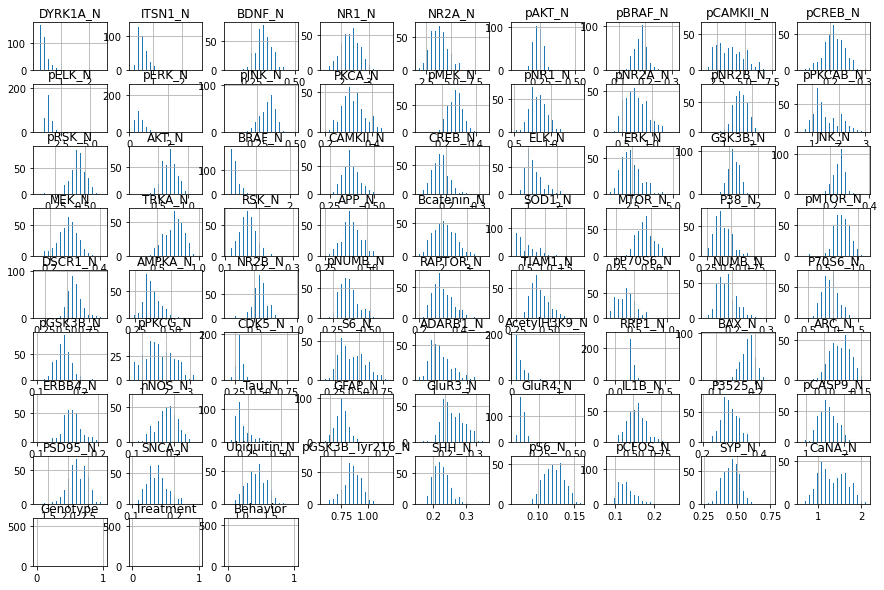

In [25]:
X.hist(bins=50, figsize=(15,10), ec = 'w')
plt.show

Looking at this first plot I can see that a clustering pattern may exist

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


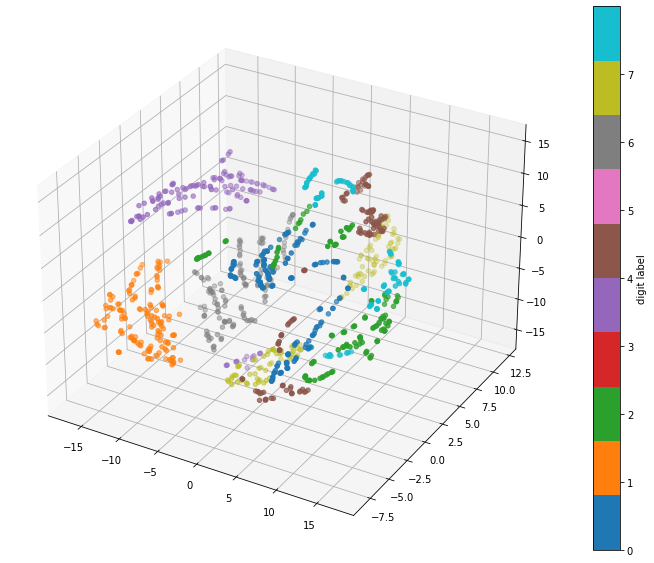

In [26]:
plot3d(X, labels=y)

In [27]:
# Calculate the z-scores
z_scores = stats.zscore(X)
z_scores

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0     0.312276  0.517214  2.250537  1.495281  2.301162 -0.344540 -0.158381   
1     0.356302  0.286103  1.877666  1.418035  1.974021 -0.517406 -0.334058   
2     0.334500  0.449839  2.010130  1.123297  1.906495 -0.580490 -0.226576   
3     0.065383 -0.000103  0.801008  0.488800  1.217551 -0.247080 -0.199184   
4     0.036631  0.001303  0.804572  0.197377  0.937896 -0.482088 -0.304093   
...        ...       ...       ...       ...       ...       ...       ...   
1072 -0.685867 -0.610324 -1.301211 -0.591093 -1.333701 -0.515017 -0.391591   
1073 -0.616307 -0.568293 -1.366503 -0.391434 -1.117700  0.435071  0.024045   
1074 -0.790827 -0.882315 -1.721434 -1.624989 -1.740259 -0.300442 -0.755154   
1075 -0.820746 -0.811884 -1.521758 -1.212571 -1.565239 -0.583234 -0.304226   
1076 -0.494228 -0.620391 -1.266690 -0.589052 -1.339799  0.428527  0.368665   

      pCAMKII_N   pCREB_N    pELK_N  ...  Ubiquitin_N  pGSK3B_Tyr216_N  \
0     -0.898651  0.603275  0.690514  ...    -1.118328        -0.178153   
1     -0.961679  0.442043  0.359331  ...    -1.320337         0.010361   
2     -0.968487  0.542580  0.284204  ...    -1.395368        -0.016901   
3     -1.069707 -0.170998  0.356565  ...    -1.433488        -0.159846   
4     -1.083833 -0.626799  0.161882  ...    -1.390030         0.323214   
...         ...       ...       ...  ...          ...              ...   
1072  -0.813684 -0.161392 -0.794346  ...     0.128807         1.220078   
1073  -0.791285  0.115597 -0.744679  ...     0.089790         1.440884   
1074  -1.195291 -0.841508 -1.166391  ...     0.017129         1.365525   
1075  -1.120900 -0.630299 -1.084426  ...     0.355707         1.500438   
1076  -0.907865  0.339482 -0.781244  ...     0.160285         1.831370   

         SHH_N     pS6_N   pCFOS_N     SYP_N    CaNA_N  Genotype  Treatment  \
0    -1.307987 -1.065374 -0.989971 -0.286572  1.065729 -0.943119  -0.943119   
1    -0.909333 -1.045291 -1.164703 -0.068718  1.279868 -0.943119  -0.943119   
2    -1.141206 -0.925551 -1.081960 -0.156034  1.855939 -0.943119  -0.943119   
3    -1.195478 -1.283834 -0.862800 -0.819218  1.144226 -0.943119  -0.943119   
4    -0.729861 -1.171855 -0.887488 -0.180450  1.582752 -0.943119  -0.943119   
...        ...       ...       ...       ...       ...       ...        ...   
1072  1.683859 -0.400462  2.269082 -1.084025  0.086281  1.060311   1.060311   
1073  1.948175 -0.553828  1.936599 -1.066402  0.085195  1.060311   1.060311   
1074  2.211709 -0.180522  1.181324 -0.361452  0.294259  1.060311   1.060311   
1075  2.758944  0.263668  2.832842 -0.729190  0.209829  1.060311   1.060311   
1076  2.263009 -0.184000  2.453005 -0.388148  0.105744  1.060311   1.060311   

      Behavior  
0    -1.025392  
1    -1.025392  
2    -1.025392  
3    -1.025392  
4    -1.025392  
...        ...  
1072  0.975237  
1073  0.975237  
1074  0.975237  
1075  0.975237  
1076  0.975237  

[1077 rows x 75 columns]

In [28]:
# Convert to absolute values
abs_z_scores = np.abs(z_scores)

# Select data points with a z-scores above or below 3
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Filter the dataset
X_wo_outliers =X[filtered_entries]
X_wo_outliers.shape

(843, 75)

After a close look at Z stat and outliers, I decide to use MinMax scaling because this dataset presents too many outliers and this method is ideal in this case.

(All further analyses are performed on scaled data, I also performed analyses with non-scaled data but I removed them because none of them were significant or interesting in any case)

In [29]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.head()

0         1         2         3         4         5         6   \
0  0.151122  0.212885  0.824638  0.612119  0.630482  0.327006  0.448666   
1  0.155750  0.188226  0.776455  0.601070  0.585247  0.311887  0.429899   
2  0.153459  0.205696  0.793572  0.558911  0.575910  0.306369  0.441381   
3  0.125169  0.157688  0.637326  0.468152  0.480646  0.335530  0.444307   
4  0.122146  0.157838  0.637787  0.426467  0.441977  0.314976  0.433100   

         7         8         9   ...        65        66        67        68  \
0  0.168257  0.617322  0.232553  ...  0.256699  0.405228  0.162941  0.426816   
1  0.154925  0.590173  0.205362  ...  0.226088  0.433471  0.220010  0.429952   
2  0.153485  0.607102  0.199194  ...  0.214719  0.429387  0.186816  0.448652   
3  0.132074  0.486945  0.205135  ...  0.208943  0.407971  0.179047  0.392700   
4  0.129086  0.410194  0.189152  ...  0.215528  0.480342  0.245702  0.410187   

         69        70        71   72   73   74  
0  0.133930  0.336299  0.705738  0.0  0.0  0.0  
1  0.110434  0.365208  0.749771  0.0  0.0  0.0  
2  0.121560  0.353621  0.868229  0.0  0.0  0.0  
3  0.151031  0.265619  0.721879  0.0  0.0  0.0  
4  0.147711  0.350381  0.812053  0.0  0.0  0.0  

[5 rows x 75 columns]

I ran the PCA and I plotted it to see which reduced number of PCs were able to explain the 80% of variance

Text(0, 0.5, 'Cumulative Explained Variance')

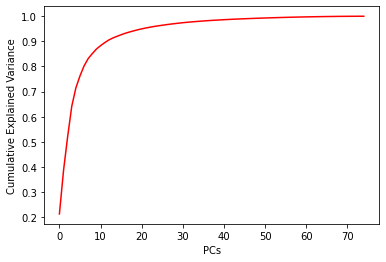

In [30]:
pca = PCA().fit(X) 
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='red') 
plt.xlabel('PCs') 
plt.ylabel('Cumulative Explained Variance')

In [31]:
pca = PCA(0.80).fit(X)
pca.n_components_ 

7

I decided to prepare a reduced 7 pcs dataset to further compare it, for the same analyses, with the full one

In [32]:
pca = PCA(n_components=7, random_state=0)
X_pca7 = pca.fit(X).transform(X)

# Clustering

### AgglomerativeClustering

I compare different metrics and linkage method using the 'AgglomerativeClustering' function, then I kept the best one according to purity and correlation scores to compare further with other clustering methods.
This hierarchical clustering method produces an output based on the number of clusters in input by the user 

The first plot is based on defult parametrs of affinity (euclidiean) and linkage (ward)

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

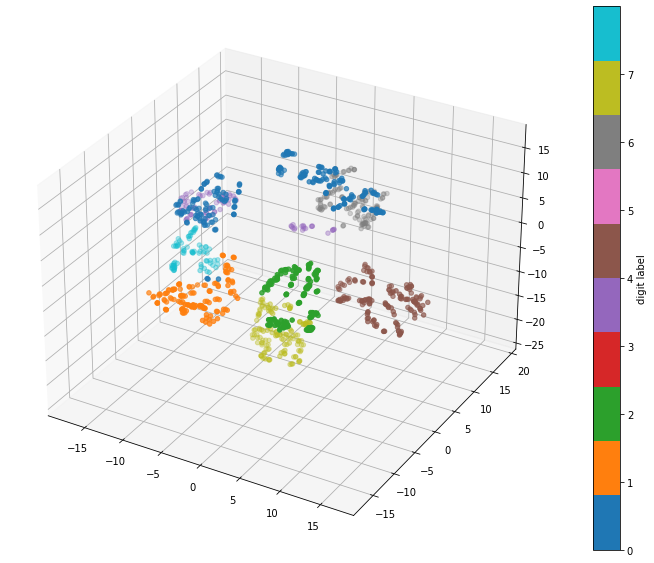

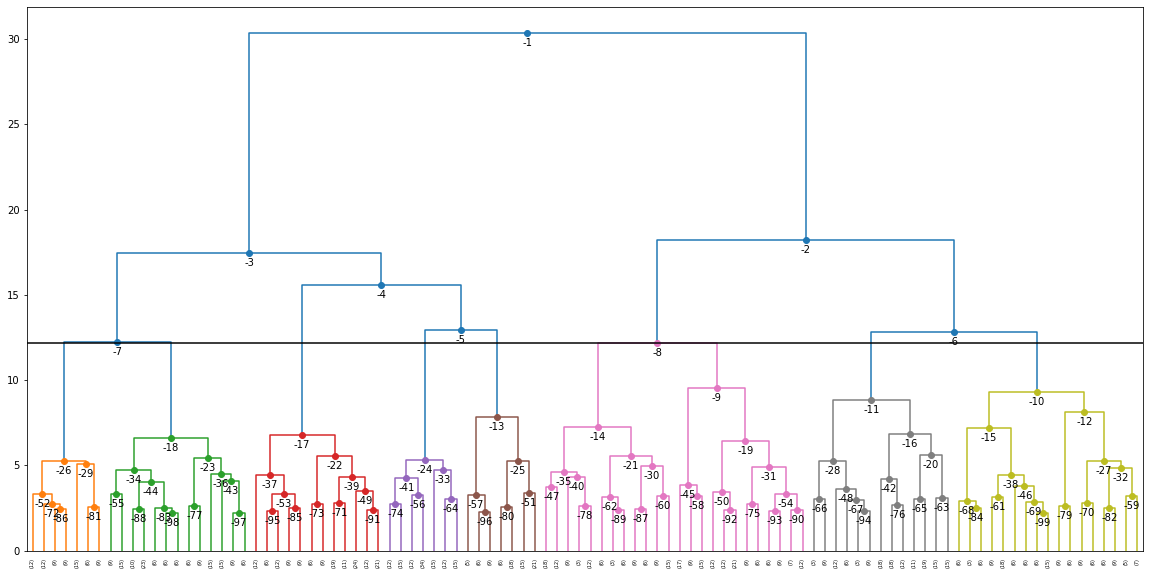

In [33]:
distance_threshold=None
n_clusters=8

# distance: euclidean linkage: ward

model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold, 
                                affinity='euclidean', linkage='ward')

y_predict = model.fit_predict(X)

plot3d(X, labels=y_predict)
plot_dendrogram(model=model, X=X, truncate_mode='lastp', p=100, 
                n_clusters=n_clusters, 
                color_threshold=distance_threshold)

I computed the clustering correlation which is the correlation between incidence and similarity matrices to have an idea of how the defult hierarchical clustering model performs

In [34]:
correlation(X, y_predict, metric='euclidean')

0.45914422487450013

Here I tried different combinations of affinity and linkage for agglomerative clustering models to have an idea of how they cluster this data

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

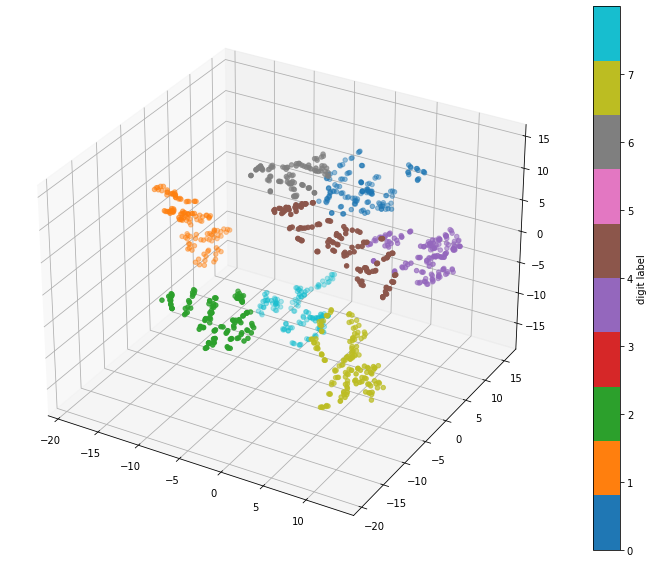

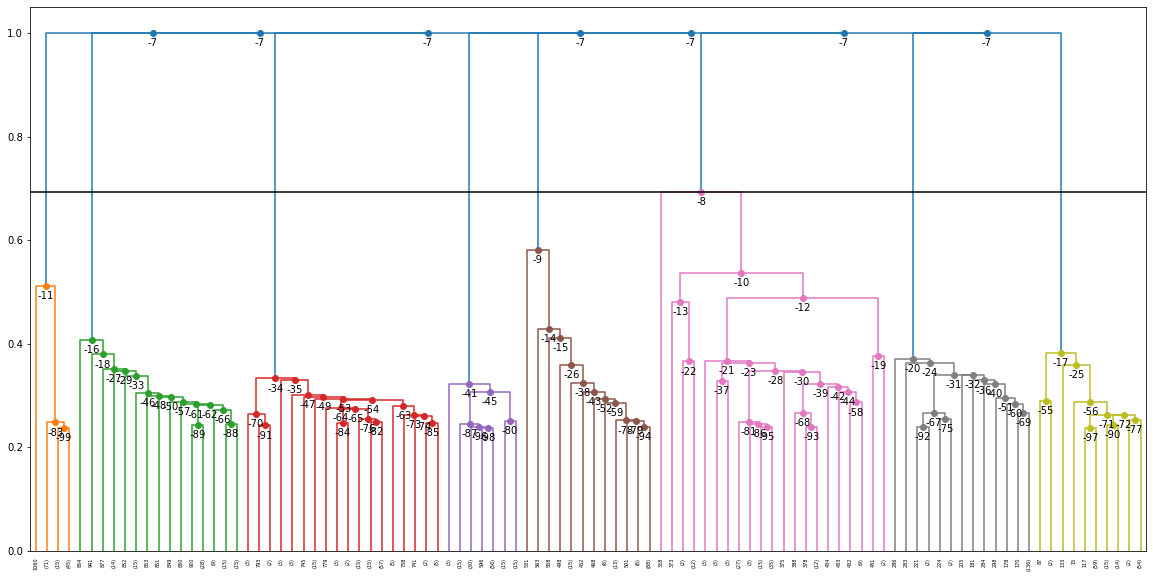

In [35]:
# distance: chebyshev linkage: single

model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold, 
                                affinity='chebyshev', linkage='single')

y_predict = model.fit_predict(X)

plot3d(X, labels=y_predict)
plot_dendrogram(model=model, X=X, truncate_mode='lastp', p=100, 
                n_clusters=n_clusters, 
                color_threshold=distance_threshold)

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

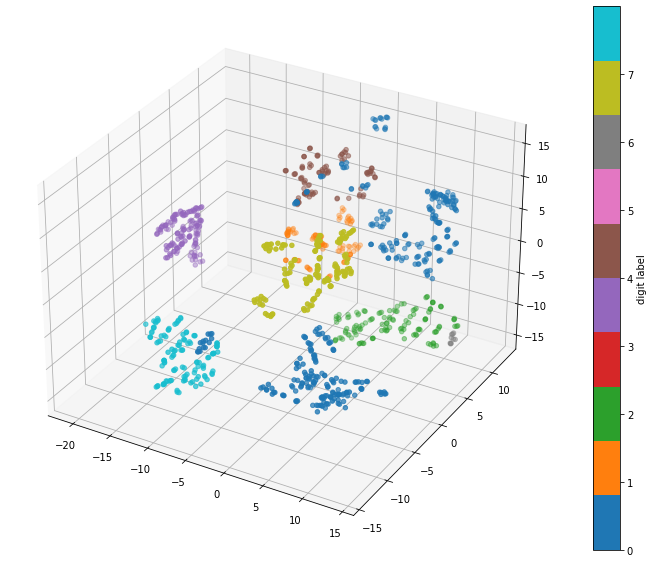

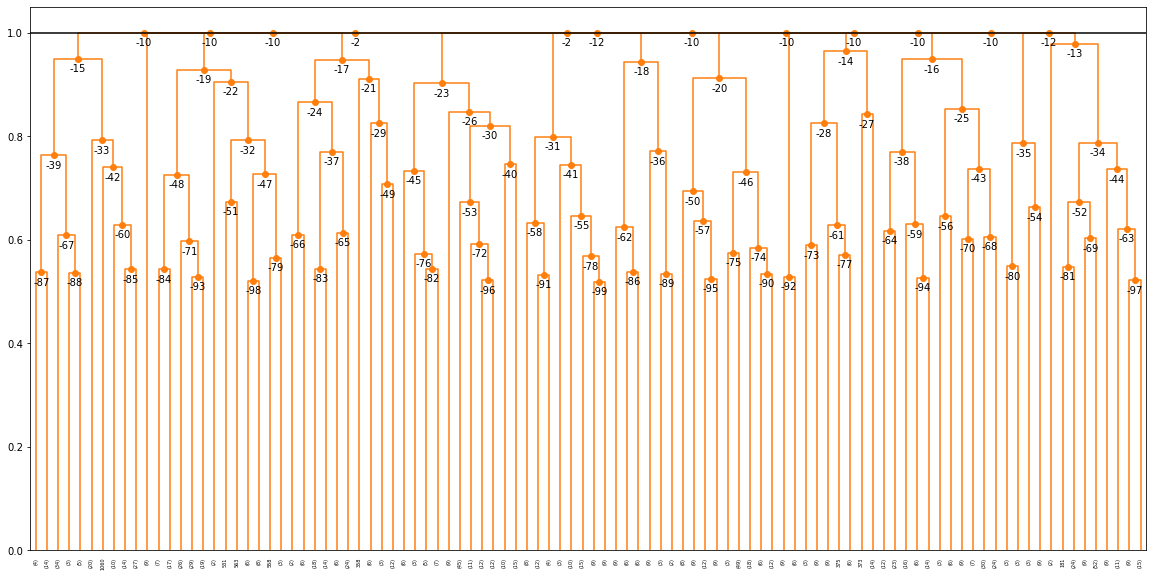

In [36]:
# distance: minkowski linkage: single

model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold, 
                                affinity='chebyshev', linkage='complete')

y_predict = model.fit_predict(X)

plot3d(X, labels=y_predict)
plot_dendrogram(model=model, X=X, truncate_mode='lastp', p=100, 
                n_clusters=n_clusters, 
                color_threshold=distance_threshold)

Also plotted the matrices for two different metrics to have an idea of the clusterization

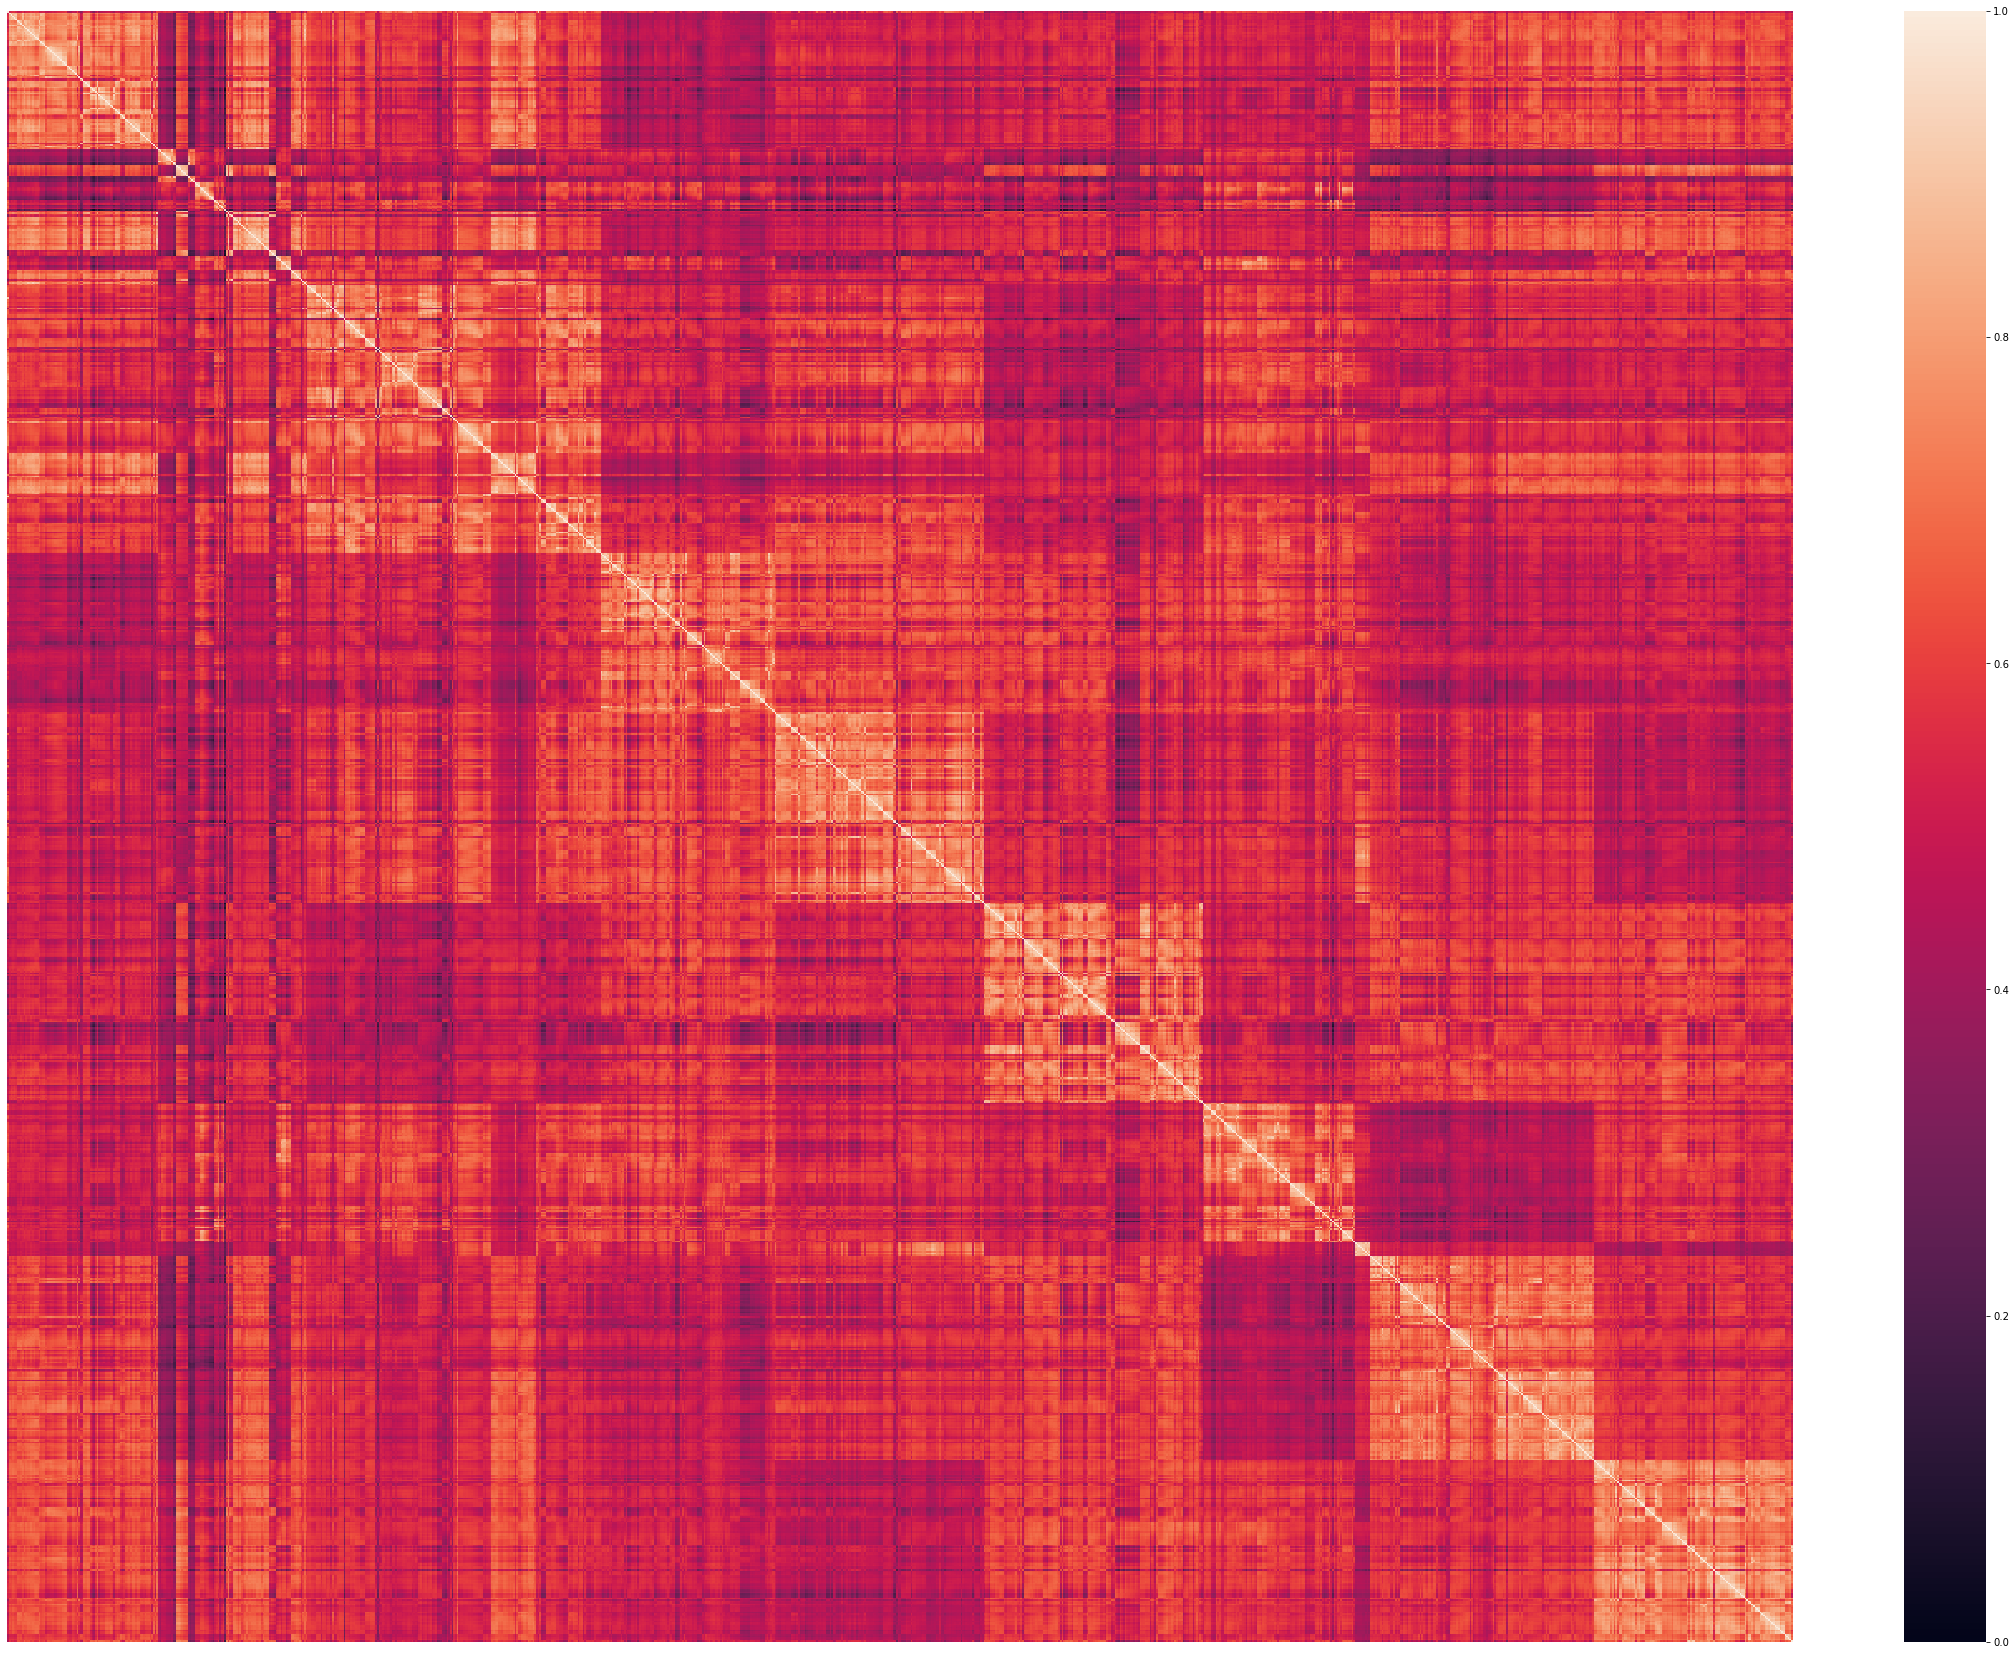

In [37]:
sim = similarity_mat(X, 'euclidean')
plot_sorted_mat(sim, y_predict)

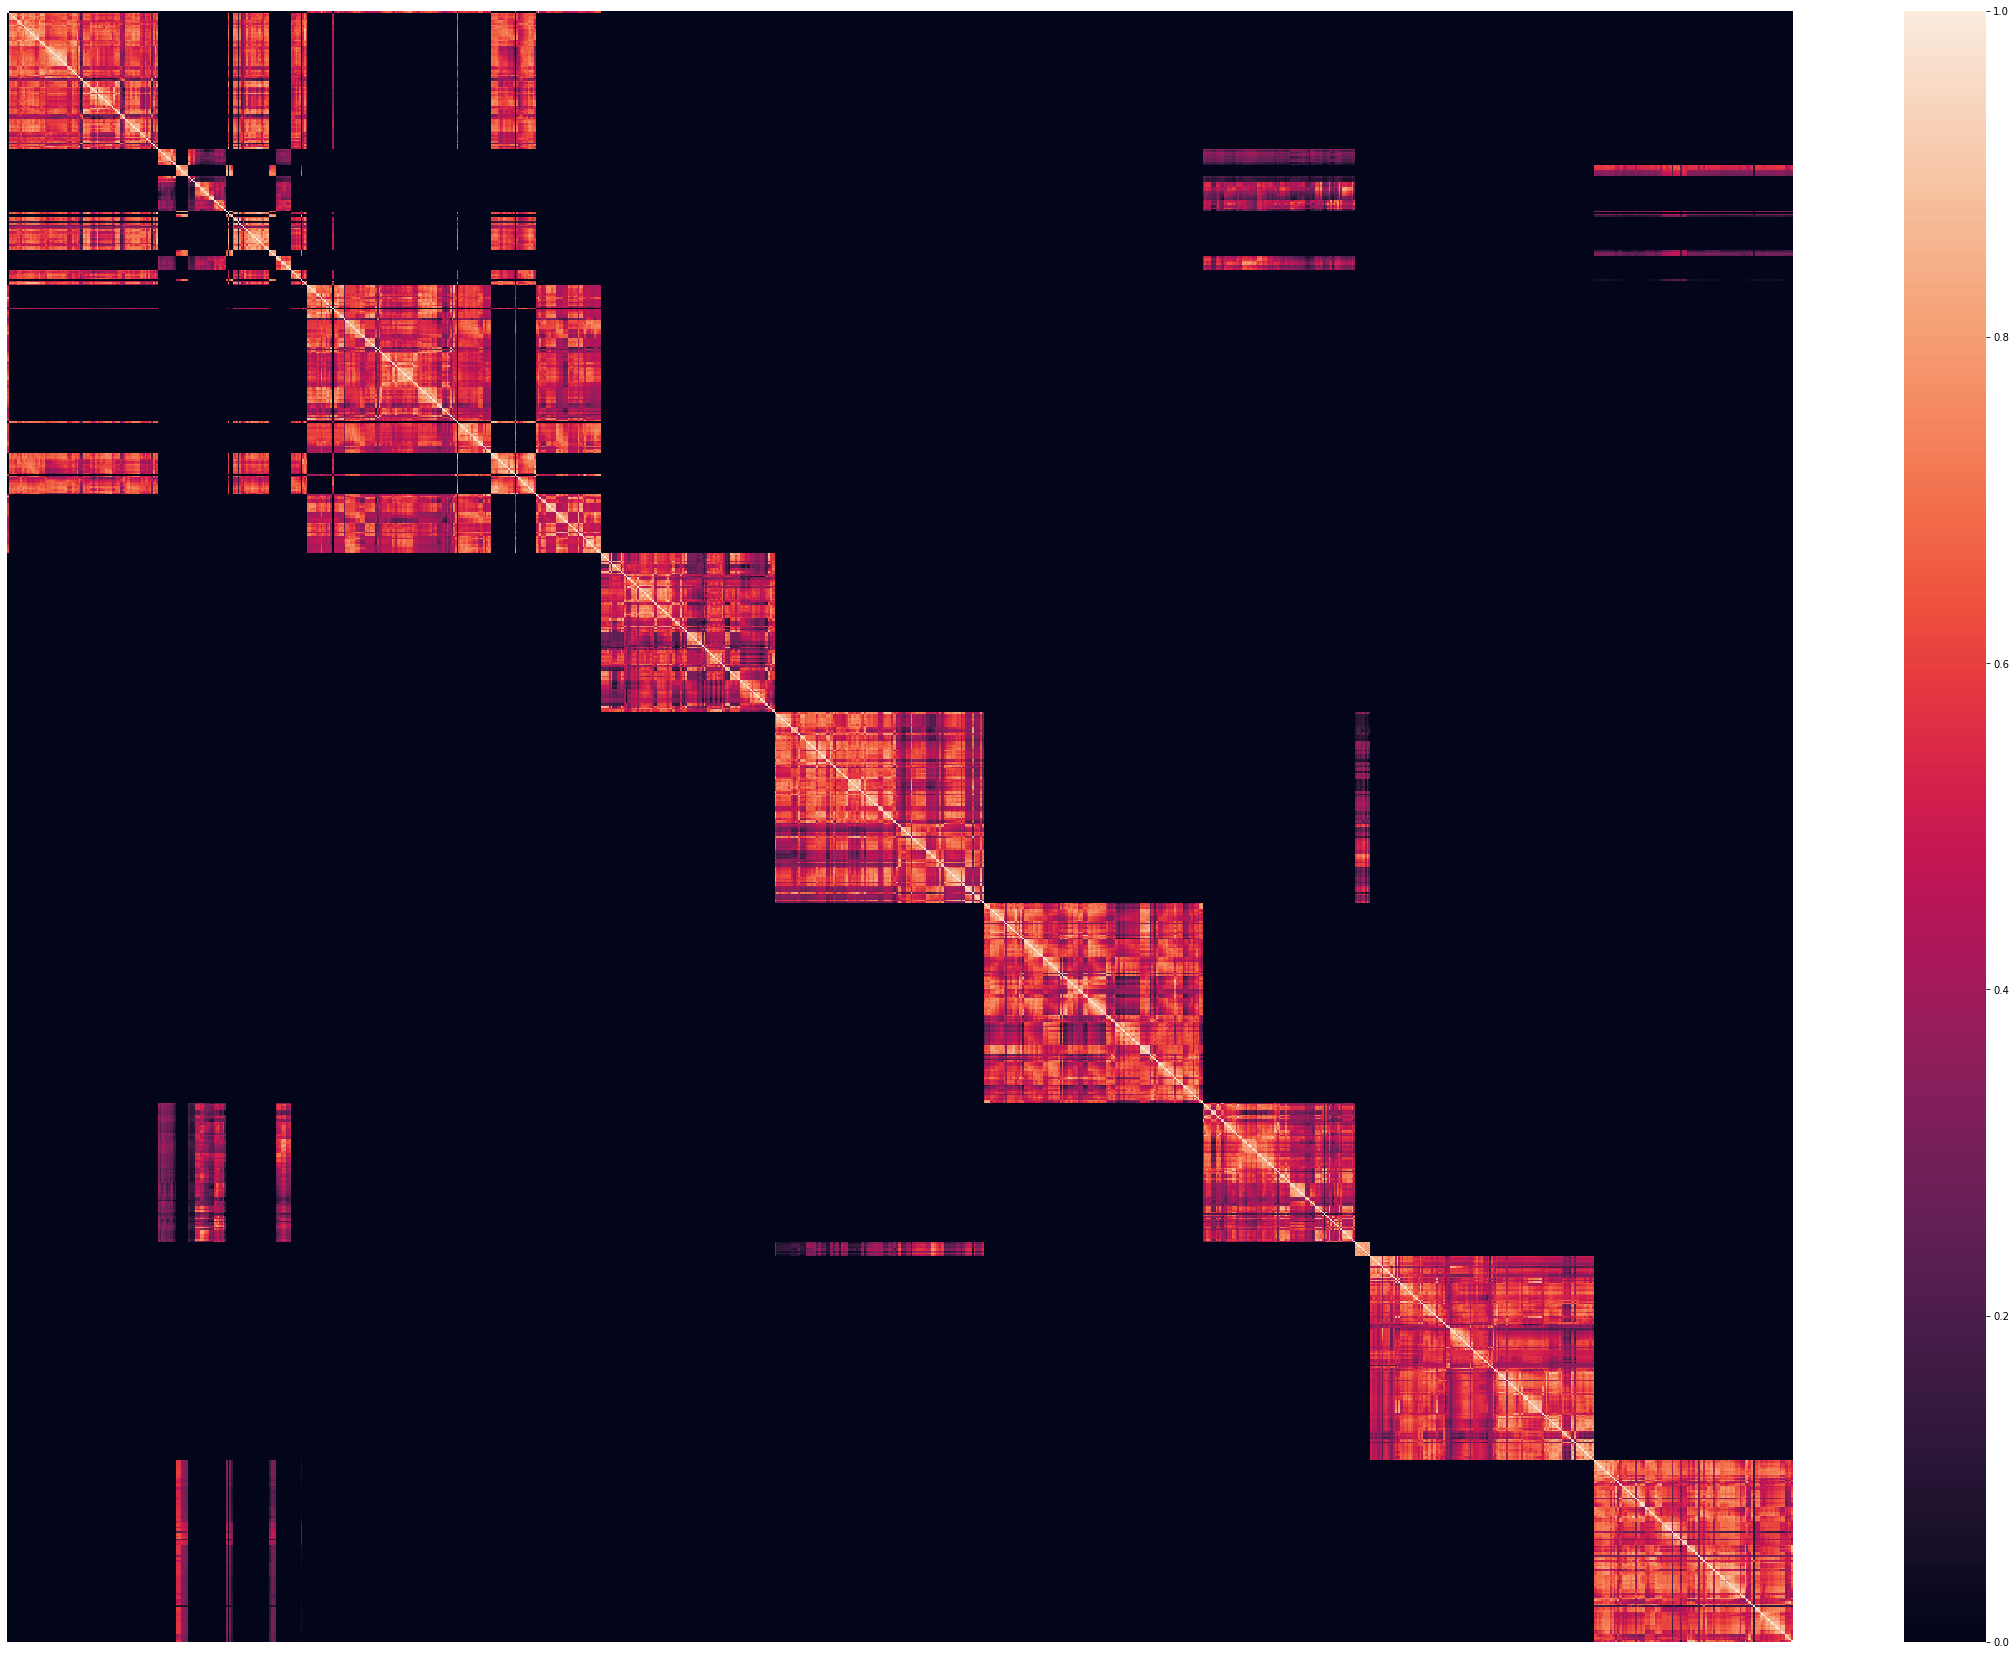

In [38]:
sim = similarity_mat(X, 'chebyshev')
plot_sorted_mat(sim, y_predict)

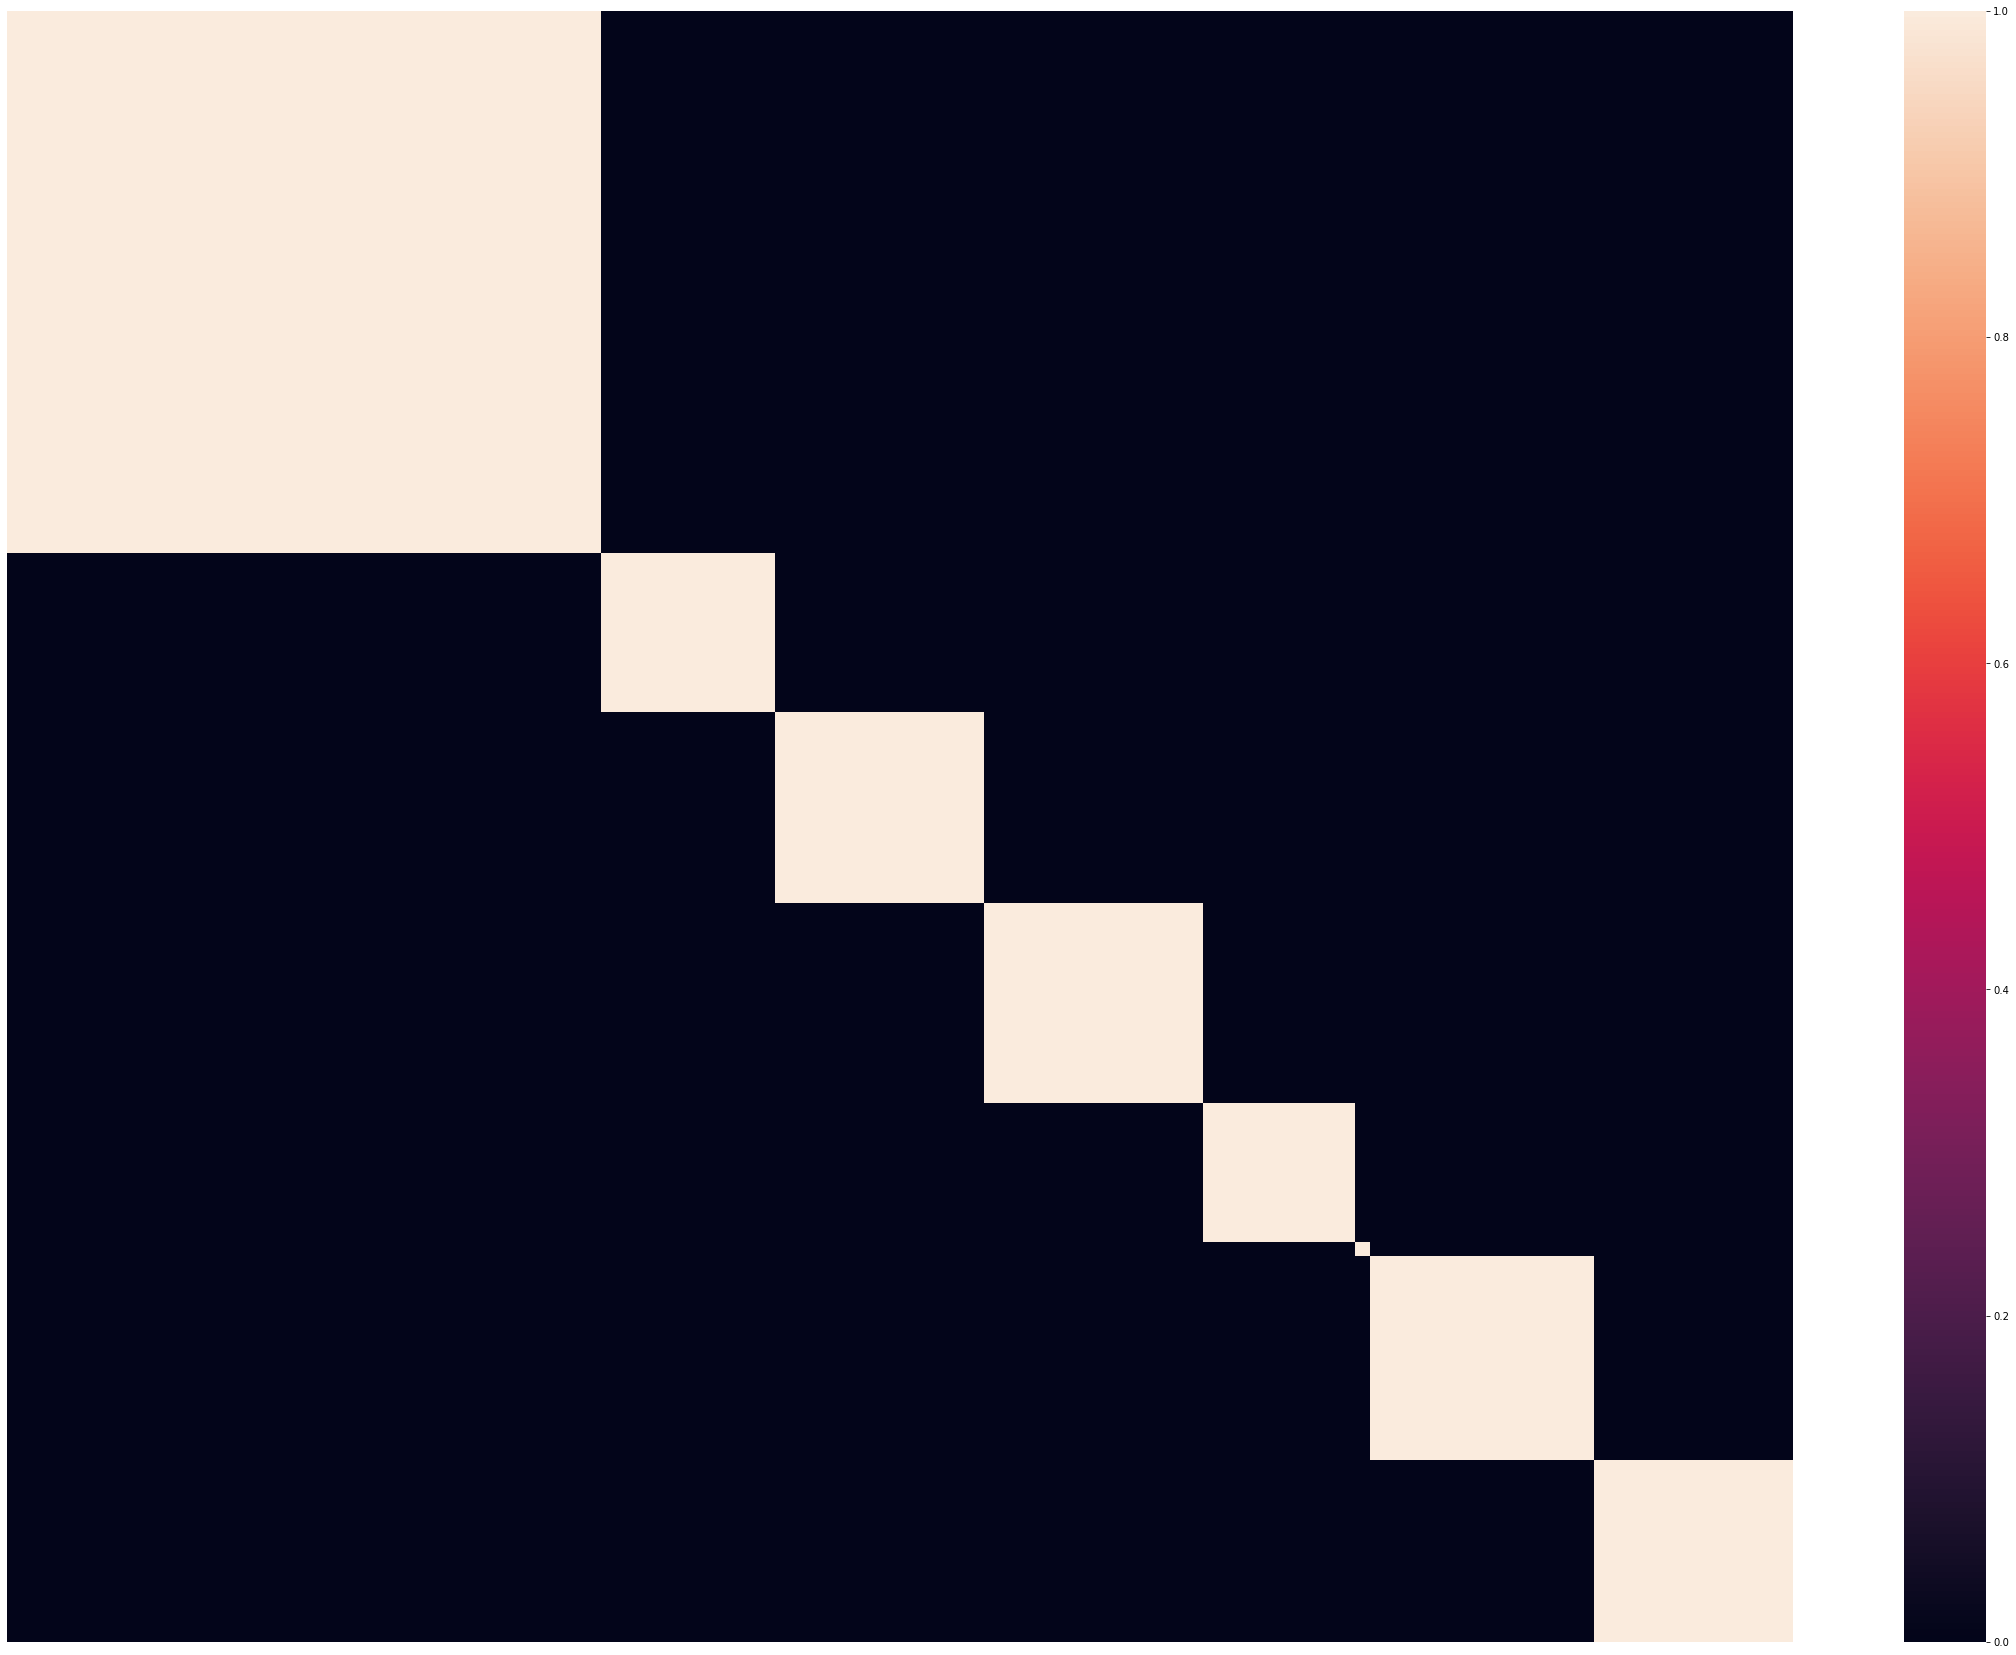

In [39]:
# Plot the sorted indicence matrix and compare it with the similarity one
inc = incidence_mat(y_predict)
plot_sorted_mat(inc, y_predict)

I combined all affinities and linkage methods to choose the best model among all possibles combinations using correlation, purity and shiluette scores to determine which performs better

In [40]:
mtrs = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'hamming', 
            'minkowski', 'sqeuclidean']
lkgs = ['average', 'single', 'complete']

for mt in mtrs:
    print(mt)

    if mt == 'euclidean':
        print('ward')
        model = AgglomerativeClustering(n_clusters=n_clusters, affinity = mt, linkage = 'ward')
        
        y_predict = model.fit_predict(X)

        print('correlation =', correlation(X, y_predict, metric = mt))
        print('silhouette =', silhouette_score(X, y_predict, metric=mt))
        print(f'total purity = {tot_purity(y_predict, y)}\n')
        
    else:
        for lkg in lkgs:
            print(lkg)
            model = AgglomerativeClustering(n_clusters=n_clusters, affinity = mt, linkage = lkg)
        
            y_predict = model.fit_predict(X)

            print('correlation = ', correlation(X, y_predict, metric = mt))
            print('silhouette = ', silhouette_score(X, y_predict, metric = mt))
            print(f'total purity = {tot_purity(y_predict, y)}\n')

braycurtis
average
correlation =  0.7011382799426181
silhouette =  0.15472031880454964
total purity = 0.34447539456200243

single
correlation =  0.9689351819029599
silhouette =  0.08507768905118474
total purity = 0.1652739089401765

complete
correlation =  0.547894641023116
silhouette =  0.11704464029122756
total purity = 0.39090064991478796

canberra
average
correlation =  0.9321417772114369
silhouette =  0.18192077760615552
total purity = 0.19034354683556579

single
correlation =  0.9811568144580334
silhouette =  0.1992305712922666
total purity = 0.14763231191142392

complete
correlation =  0.630273262112812
silhouette =  0.15534373503856458
total purity = 0.32404828222387694

chebyshev
average
correlation =  0.9515126405026714
silhouette =  0.5169777394066128
total purity = 0.9999999999257196

single
correlation =  0.9515126405026714
silhouette =  0.5169777394066128
total purity = 0.9999999999257198

complete
correlation =  0.7409148919575496
silhouette =  0.3734832473808552
total p

In the end the affinity chebyshev and linkage average (or single) is the best combination, so I plotted a hierarchical clustering model with these parameters both with reduced number of PCs and full data

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

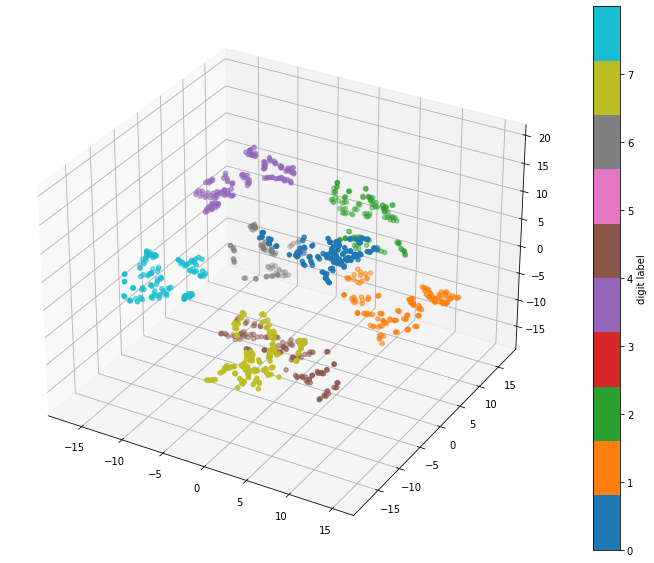

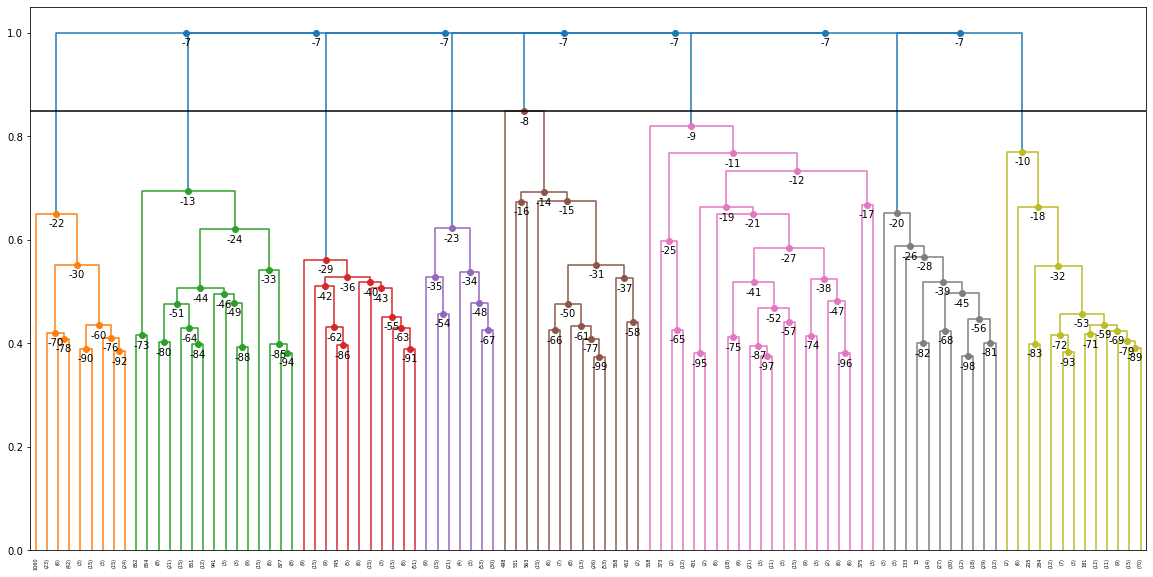

In [41]:
# distance: chebyshev linkage: average 

model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold, affinity='chebyshev', linkage='average')

y_predict_agg_chb_avg = model.fit_predict(X)

plot3d(X, labels=y_predict_agg_chb_avg)
plot_dendrogram(model=model, X=X, truncate_mode='lastp', p=100,  n_clusters=n_clusters, color_threshold=distance_threshold)

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

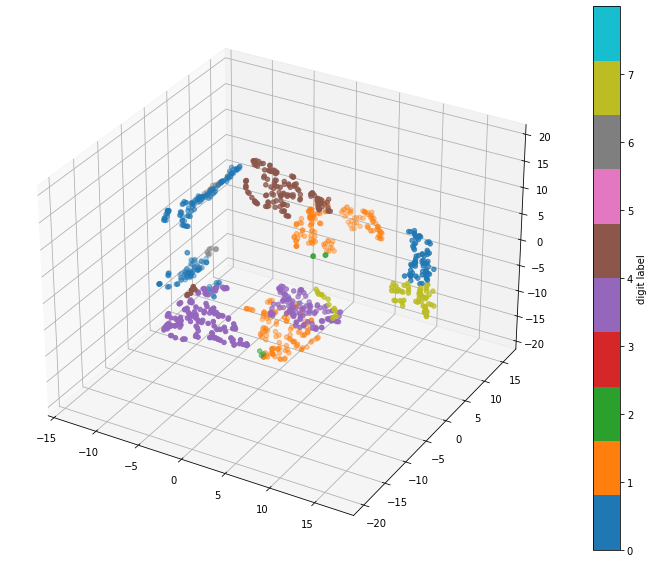

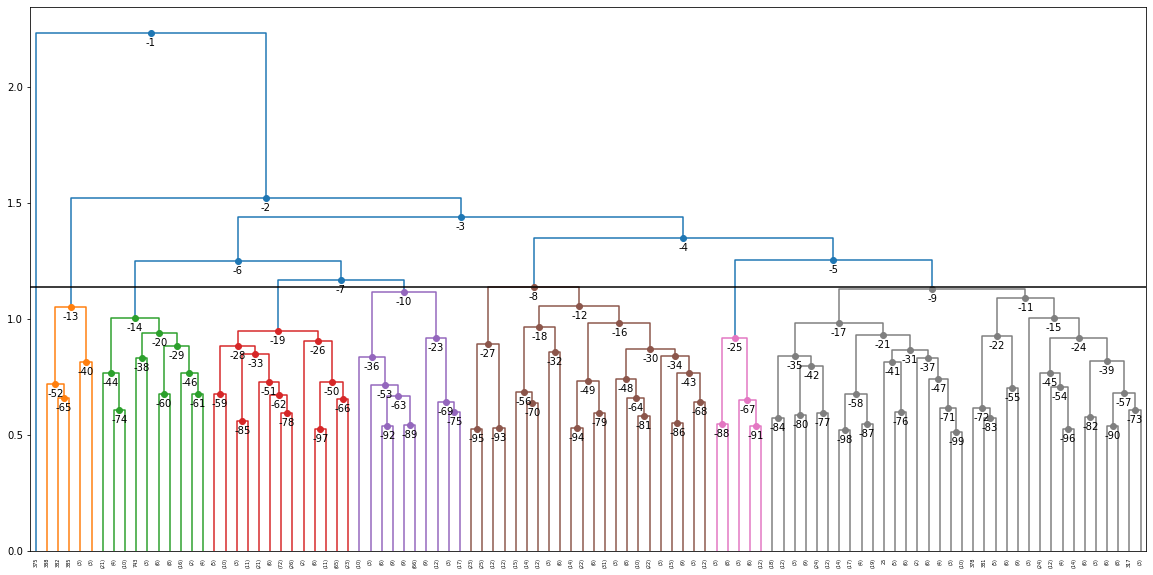

In [42]:
# distance: chebyshev linkage: average with pcs of 7

model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold, affinity='chebyshev', linkage='average')

y_predict_pca_agg_chb_avg = model.fit_predict(X_pca7)

plot3d(X_pca7, labels=y_predict_pca_agg_chb_avg)
plot_dendrogram(model=model, X=X_pca7, truncate_mode='lastp', p=100, 
                n_clusters=n_clusters, 
                color_threshold=distance_threshold)

## Kmeans

I plotted Kmeans clusters both with and without pca using random initialization just to see if there is any difference between them

Kmeans purity 0.7613741874990624


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


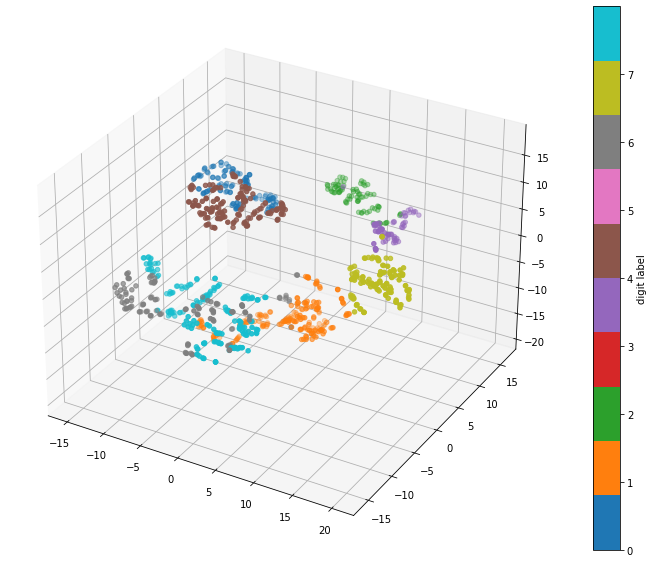

In [43]:
model = KMeans(n_clusters=8, init='random', random_state=0)             
y_predict_km = model.fit_predict(X)
print("Kmeans purity", tot_purity(y_predict_km, y))

plot3d(X, labels=y_predict_km)

# purity is higher for minmax scale in compare to untouched data while it's worst if I use normalization scaling

Kmeans purity 0.7623026926063815


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


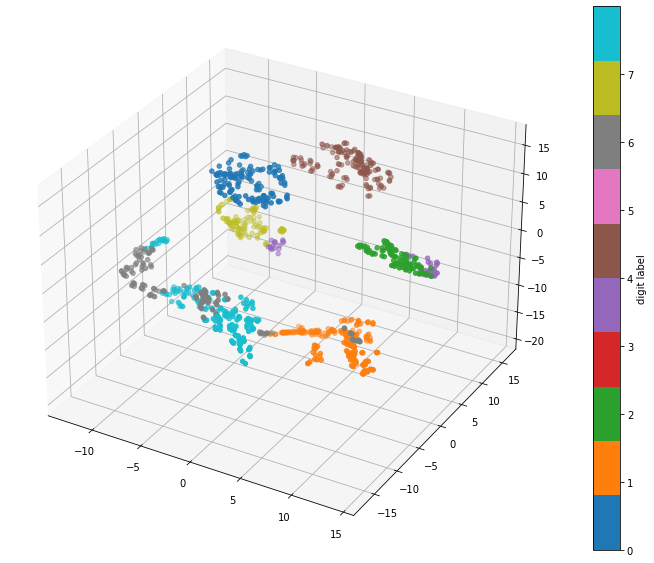

In [44]:
# trying kmeans with pcs of 7 

model = KMeans(n_clusters=8, init='random', random_state=0)             
y_predict_km_pca7 = model.fit_predict(X_pca7)
print("Kmeans purity", tot_purity(y_predict_km_pca7, y))

plot3d(X_pca7, labels=y_predict_km_pca7)

In the end there was no significant difference between them using purity as scorer indicator

Then I decided to change initialization with the most interesting options available: random, kmean++ and the combination of agglomerative hierarchical and kmeans (both with and without pca)

In [45]:
# Random
model = KMeans(n_clusters=8, init='random', random_state=0)             
print("Random Kmeans purity: ", tot_purity(model.fit_predict(X), y))

# K-Means++
model = KMeans(n_clusters=8, init='k-means++', random_state=0)             
print("Kmeans++ purity: ", tot_purity(model.fit_predict(X), y))

# Hierarchical_euclidian
H_k_model = AgglomerativeClustering(n_clusters=8, 
                                 distance_threshold=distance_threshold, 
                                 affinity='chebyshev', linkage='average') # Here I used the best combination of affinity/linkage
                                                                          # from previous agglomerative clustering method

y_predict = H_k_model.fit_predict(X)
centroids = np.stack([X[y_predict==k].mean(0) for k in range(8)])
model = KMeans(n_clusters=8, init=centroids, n_init=1, random_state=0)             
print("Hierarchical+Kmeans purity: ", tot_purity(model.fit_predict(X), y))

# Hierarchical_euclidian with pca
H_k_model = AgglomerativeClustering(n_clusters=8, 
                                 distance_threshold=distance_threshold, 
                                 affinity='chebyshev', linkage='average') 

y_predict_hk = H_k_model.fit_predict(X_pca7)
centroids = np.stack([X_pca7[y_predict==k].mean(0) for k in range(8)])
model = KMeans(n_clusters=8, init=centroids, n_init=1, random_state=0)             
print("Hierarchical+Kmeans purity (pca): ", tot_purity(model.fit_predict(X_pca7), y))

Random Kmeans purity:  0.7613741874990624
Kmeans++ purity:  0.8727948003055661
Hierarchical+Kmeans purity:  0.9999999999257196
Hierarchical+Kmeans purity (pca):  0.9619312905504402


I kept for the final comparisons the hierarchical+Kmeans model with complete dataset because here is the best according to purity

## DBSCAN

This clustering method finds core samples of high density and expands clusters from them, it needs two principal hyperparameters: 'eps' which is the maximum distance between two samples for one to be considered as in the neighborhood of the other and 'min_samples' which are the number of samples in a neighborhood for a point to be considered as a core point.
Moreover I tried with an enhanced version of DBSCAN that is OPTICS, this method doesn't require eps as parameter for the fact that it returns the best model with the best number of epsilon

First try is DBSCAN with defult parameters for eps and min_samples, for the moment every model is evaluated with purity

DBSCAN purity 0.06035283186629525
Number of outliers 417
   -1    0    1    2    3    4    5    6    7    8   ...   56   57   58   59  \
0  417   12    5    6    6   13    7   11    5   11  ...    5   18    7    7   

    60   61   62   63   64   65  
0   12   12    6   11   14    9  

[1 rows x 67 columns]


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


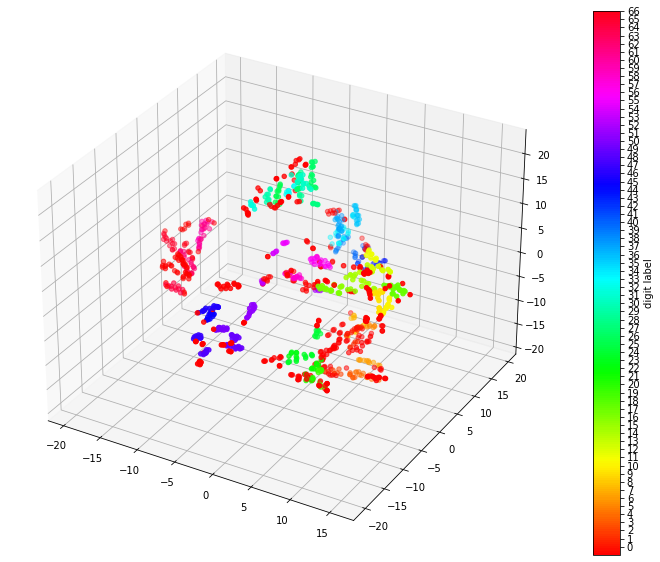

In [46]:
model_dbs1 = DBSCAN(eps=0.5, min_samples=5)
y_predict_db_def = model_dbs1.fit_predict(X)
print("DBSCAN purity", tot_purity(y_predict_db_def, y))

print("Number of outliers", (y_predict_db_def == -1).sum())
ids, counts = np.unique(y_predict_db_def, return_counts=True)
print(pd.DataFrame(counts.reshape(1,-1), columns=ids)) # eventually index=['']

plot3d(X, labels=y_predict_db_def)

OPTICS in this case has 4 minimum points per cluster but neither this model has a good result in purity

OPTICS purity 0.05756731654596099
Number of outliers 392
   -1    0    1    2    3    4    5    6    7    8   ...   90   91   92   93  \
0  392    6    6    6    9    9    5   15    6    6  ...    6   12    4    5   

    94   95   96   97   98   99  
0    6    9    7    6    9   12  

[1 rows x 101 columns]


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


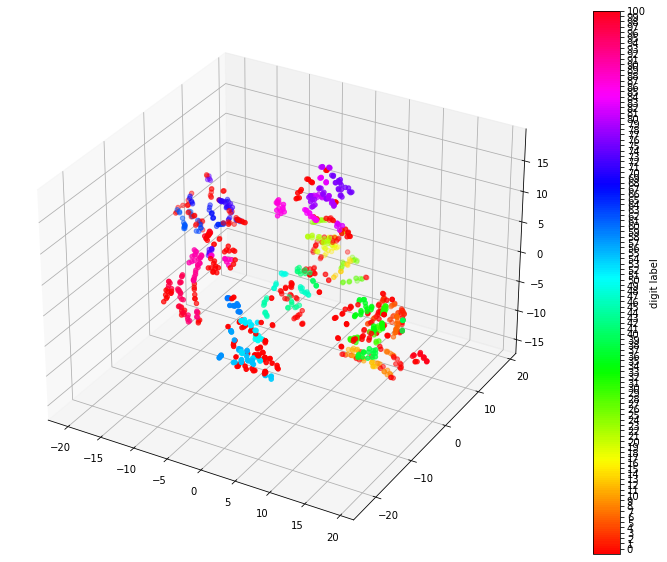

In [47]:
# OPTICS

model_opt = OPTICS(min_samples=4)
y_predict_opt4 = model_opt.fit_predict(X)
print("OPTICS purity", tot_purity(y_predict_opt4, y))

print("Number of outliers", (y_predict_opt4 == -1).sum())
ids, counts = np.unique(y_predict_opt4, return_counts=True)
print(pd.DataFrame(counts.reshape(1,-1), columns=ids)) # eventually index=['']

plot3d(X, labels=y_predict_opt4)

To improve my models I decided to use GridSearch to iteratively search from the range of parameter indicated, the best combination of eps and min_samples according to purity. Having a consistent amount of data I kept the number of k-folds to three to not overcharge the system, but with a more powerful machine it is possible to increase 'cv' parameter without having an increase in computation time

In [48]:
params = {'eps': range(3,10), 'min_samples': range(3,25)} 

cv = GridSearchCV(DBSCAN(), params, scoring=make_scorer(tot_purity), cv=3)
cv = cv.fit(X, y)
print(cv.best_params_)
print("CV score (tot purity): ", tot_purity(cv.best_estimator_.fit_predict(X), y))

pd.DataFrame(cv.cv_results_)

{'eps': 3, 'min_samples': 3}
CV score (tot purity):  0.1392757660154199


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eps  \
0         0.021017      0.005688         0.012096        0.003141         3   
1         0.026206      0.007491         0.005209        0.007366         3   
2         0.030913      0.003831         0.005564        0.007869         3   
3         0.015647      0.000014         0.015765        0.000204         3   
4         0.014762      0.001231         0.016639        0.001416         3   
..             ...           ...              ...             ...       ...   
149       0.014328      0.001867         0.016608        0.001448         9   
150       0.015641      0.000025         0.015626        0.000008         9   
151       0.015782      0.000214         0.016987        0.001900         9   
152       0.014155      0.002089         0.015630        0.000014         9   
153       0.026320      0.007558         0.010424        0.007371         9   

    param_min_samples                         params  split0_test_score  \
0                   3   {'eps': 3, 'min_samples': 3}           0.417827   
1                   4   {'eps': 3, 'min_samples': 4}           0.417827   
2                   5   {'eps': 3, 'min_samples': 5}           0.417827   
3                   6   {'eps': 3, 'min_samples': 6}           0.417827   
4                   7   {'eps': 3, 'min_samples': 7}           0.417827   
..                ...                            ...                ...   
149                20  {'eps': 9, 'min_samples': 20}           0.417827   
150                21  {'eps': 9, 'min_samples': 21}           0.417827   
151                22  {'eps': 9, 'min_samples': 22}           0.417827   
152                23  {'eps': 9, 'min_samples': 23}           0.417827   
153                24  {'eps': 9, 'min_samples': 24}           0.417827   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.376045           0.367688         0.387187        0.021933   
1             0.376045           0.367688         0.387187        0.021933   
2             0.376045           0.367688         0.387187        0.021933   
3             0.376045           0.367688         0.387187        0.021933   
4             0.376045           0.367688         0.387187        0.021933   
..                 ...                ...              ...             ...   
149           0.376045           0.367688         0.387187        0.021933   
150           0.376045           0.367688         0.387187        0.021933   
151           0.376045           0.367688         0.387187        0.021933   
152           0.376045           0.367688         0.387187        0.021933   
153           0.376045           0.367688         0.387187        0.021933   

     rank_test_score  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
..               ...  
149                1  
150                1  
151                1  
152                1  
153                1  

[154 rows x 13 columns]

We are starting to see an improvement in the model but it's not enough to feel satisfied for the analysis

DBSCAN purity 0.1392757660154199
Number of outliers 0
      0
0  1077


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


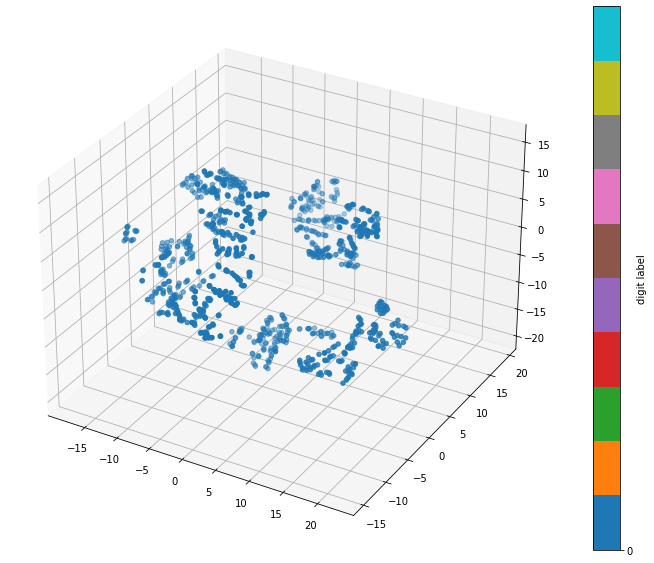

In [49]:
model_dbs2 = DBSCAN(eps=3, min_samples=3)
y_predict_db_ms3 = model_dbs2.fit_predict(X)
print("DBSCAN purity", tot_purity(y_predict_db_ms3, y))

print("Number of outliers", (y_predict_db_ms3 == -1).sum())
ids, counts = np.unique(y_predict_db_ms3, return_counts=True)
print(pd.DataFrame(counts.reshape(1,-1), columns=ids)) # eventually index=['']

plot3d(X, labels=y_predict_db_ms3)

Repeted the same process of before but this time for the OPTICS model, here I just need to insert the min_sample range of parameters

In [50]:
params = {'min_samples': range(3,25)} 

cv = GridSearchCV(OPTICS(), params, scoring=make_scorer(tot_purity), cv=3)
cv = cv.fit(X, y)
print(cv.best_params_)
print("CV score (tot purity): ", tot_purity(cv.best_estimator_.fit_predict(X), y))

pd.DataFrame(cv.cv_results_)

{'min_samples': 16}
CV score (tot purity):  0.717734447465181


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.619138      0.004986         0.266980        0.000386   
1        0.607940      0.014414         0.268228        0.011456   
2        0.618051      0.020956         0.271362        0.005388   
3        0.619266      0.028776         0.296565        0.010669   
4        0.608517      0.008470         0.272059        0.007550   
5        0.612372      0.013263         0.256267        0.007255   
6        0.612088      0.000275         0.276121        0.006451   
7        0.585284      0.012172         0.268706        0.002530   
8        0.596616      0.012215         0.261648        0.007271   
9        0.597026      0.013061         0.266388        0.012990   
10       0.602474      0.006992         0.250907        0.000016   
11       0.628035      0.021981         0.261945        0.007519   
12       0.592540      0.014142         0.270929        0.005379   
13       0.607349      0.006606         0.266100        0.000848   
14       0.596577      0.012811         0.266617        0.000470   
15       0.596541      0.000408         0.263632        0.004382   
16       0.589362      0.007158         0.266808        0.012570   
17       0.603035      0.009632         0.265559        0.002040   
18       0.579228      0.004157         0.263867        0.004054   
19       0.596728      0.021884         0.261504        0.007197   
20       0.598553      0.020127         0.255071        0.008612   
21       0.608007      0.005582         0.270946        0.008650   

   param_min_samples               params  split0_test_score  \
0                  3   {'min_samples': 3}           0.033426   
1                  4   {'min_samples': 4}           0.050139   
2                  5   {'min_samples': 5}           0.083565   
3                  6   {'min_samples': 6}           0.080780   
4                  7   {'min_samples': 7}           0.130919   
5                  8   {'min_samples': 8}           0.111421   
6                  9   {'min_samples': 9}           0.094708   
7                 10  {'min_samples': 10}           0.119777   
8                 11  {'min_samples': 11}           0.272981   
9                 12  {'min_samples': 12}           0.153203   
10                13  {'min_samples': 13}           0.278552   
11                14  {'min_samples': 14}           0.660167   
12                15  {'min_samples': 15}           0.487465   
13                16  {'min_samples': 16}           0.752089   
14                17  {'min_samples': 17}           0.749304   
15                18  {'min_samples': 18}           0.632312   
16                19  {'min_samples': 19}           0.991643   
17                20  {'min_samples': 20}           0.991643   
18                21  {'min_samples': 21}           0.991643   
19                22  {'min_samples': 22}           0.991643   
20                23  {'min_samples': 23}           0.827298   
21                24  {'min_samples': 24}           0.821727   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.033426           0.041783         0.036212        0.003939   
1            0.069638           0.066852         0.062210        0.008611   
2            0.091922           0.066852         0.080780        0.010422   
3            0.103064           0.075209         0.086351        0.012035   
4            0.111421           0.072423         0.104921        0.024319   
5            0.181058           0.108635         0.133705        0.033503   
6            0.167131           0.133705         0.131848        0.029596   
7            0.451253           0.147632         0.239554        0.150125   
8            0.434540           0.125348         0.277623        0.126270   
9            0.317549           0.181058         0.217270        0.071814   
10           0.830084           0.222841         0.443825        0.274071   
11           0.671309           0.178273  

OPTICS with 16 samples, as computed by k-folds cross validation, gives to the model a great boost in term of purity. Here we can see the plot of this clustering

OPTICS purity 0.717734447465181
Number of outliers 304
    -1   0    1   2   3    4    5    6    7
0  304  61  135  16  32  135  142  120  132


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


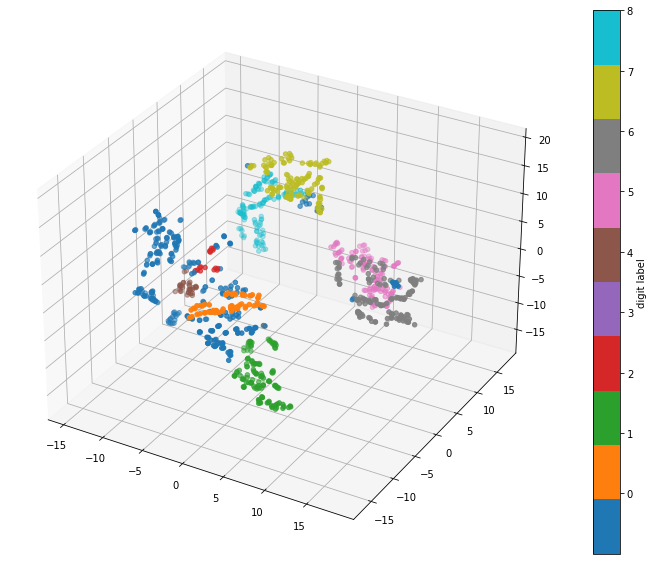

In [51]:
model_opt = OPTICS(min_samples=16)
y_predict_opt16 = model_opt.fit_predict(X)
print("OPTICS purity", tot_purity(y_predict_opt16, y))

print("Number of outliers", (y_predict_opt16 == -1).sum())
ids, counts = np.unique(y_predict_opt16, return_counts=True)
print(pd.DataFrame(counts.reshape(1,-1), columns=ids)) # eventually index=['']

plot3d(X, labels=y_predict_opt16)

Same model as before but here I tried with the reduced 7 PCs data

In [52]:
params = {'min_samples': range(3,27)} 

cv = GridSearchCV(OPTICS(), params, scoring=make_scorer(tot_purity), cv=3)
cv = cv.fit(X_pca7, y)
print(cv.best_params_)
print("CV score (tot purity): ", tot_purity(cv.best_estimator_.fit_predict(X_pca7), y))

pd.DataFrame(cv.cv_results_)

{'min_samples': 25}
CV score (tot purity):  0.8486536675301765


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.552400      0.043650         0.252552        0.013703   
1        0.542122      0.016619         0.260363        0.013055   
2        0.544546      0.014799         0.257090        0.013972   
3        0.534553      0.002912         0.239917        0.004693   
4        0.525066      0.019655         0.262595        0.006955   
5        0.534351      0.012398         0.245986        0.006514   
6        0.524419      0.006723         0.261751        0.014777   
7        0.533823      0.021170         0.261703        0.007698   
8        0.540097      0.006372         0.276778        0.006515   
9        0.550534      0.034697         0.261684        0.019348   
10       0.539790      0.004118         0.240256        0.023058   
11       0.533513      0.012756         0.261864        0.026943   
12       0.507508      0.006990         0.250967        0.000380   
13       0.502521      0.012608         0.246038        0.007320   
14       0.507268      0.007802         0.251009        0.012708   
15       0.529663      0.013593         0.261403        0.004001   
16       0.524584      0.013220         0.262254        0.006905   
17       0.526564      0.010994         0.259751        0.019652   
18       0.518544      0.013324         0.256110        0.015038   
19       0.539847      0.009663         0.263098        0.008673   
20       0.530023      0.006810         0.250728        0.002294   
21       0.518000      0.000262         0.246232        0.014152   
22       0.533326      0.021500         0.251117        0.000187   
23       0.527440      0.017356         0.286019        0.049286   

   param_min_samples               params  split0_test_score  \
0                  3   {'min_samples': 3}           0.025070   
1                  4   {'min_samples': 4}           0.058496   
2                  5   {'min_samples': 5}           0.052925   
3                  6   {'min_samples': 6}           0.089136   
4                  7   {'min_samples': 7}           0.094708   
5                  8   {'min_samples': 8}           0.080780   
6                  9   {'min_samples': 9}           0.247911   
7                 10  {'min_samples': 10}           0.284123   
8                 11  {'min_samples': 11}           0.381616   
9                 12  {'min_samples': 12}           0.311978   
10                13  {'min_samples': 13}           0.309192   
11                14  {'min_samples': 14}           0.270195   
12                15  {'min_samples': 15}           0.688022   
13                16  {'min_samples': 16}           0.654596   
14                17  {'min_samples': 17}           0.529248   
15                18  {'min_samples': 18}           0.994429   
16                19  {'min_samples': 19}           0.994429   
17                20  {'min_samples': 20}           0.991643   
18                21  {'min_samples': 21}           0.991643   
19                22  {'min_samples': 22}           0.991643   
20                23  {'min_samples': 23}           0.991643   
21                24  {'min_samples': 24}           0.991643   
22                25  {'min_samples': 25}           0.991643   
23                26  {'min_samples': 26}           0.963788   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.033426           0.030641         0.029712        0.003474   
1            0.091922           0.041783         0.064067        0.020845   
2            0.114206           0.047354         0.071495        0.030287   
3            0.142061           0.055710         0.095636        0.035551   
4            0.122563           0.069638         0.095636        0.021616   
5            0.142061           0.100279         0.107707        0.025563   
6            0.278552           0.348189         0.291551        0.041958   
7            0.153203           0.208914         0.215413        0.053645   
8        

Significant increse in purity after using the reduced number of principal component even the plot seams to be more convincing

OPTICS purity 0.8486536675301765
Number of outliers 163
    -1    0    1    2    3    4    5    6
0  163  135  126  150  135  101  132  135


C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


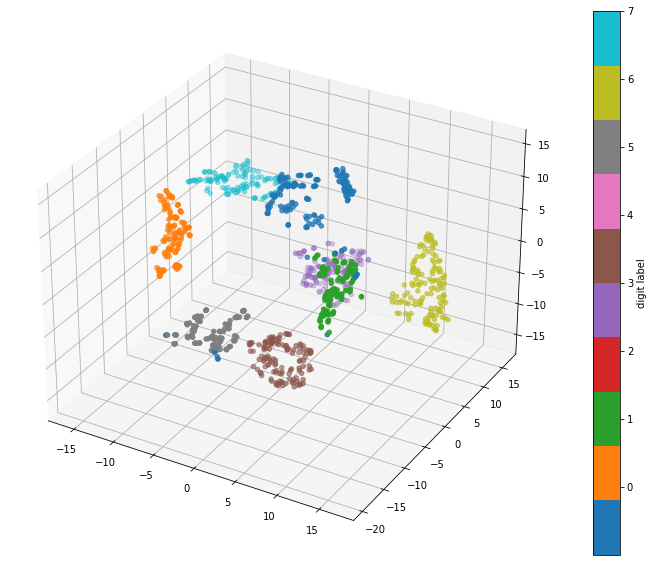

In [53]:
model_opt = OPTICS(min_samples=25)
y_predict_opt_pca = model_opt.fit_predict(X_pca7)
print("OPTICS purity", tot_purity(y_predict_opt_pca, y))

print("Number of outliers", (y_predict_opt_pca == -1).sum())
ids, counts = np.unique(y_predict_opt_pca, return_counts=True)
print(pd.DataFrame(counts.reshape(1,-1), columns=ids)) # eventually index=['']

plot3d(X_pca7, labels=y_predict_opt_pca)

## Clustering Models Evaluation

The comparison of all the models seen so far is made with two different scores: 
- Purity: is a measure of the extent to which clusters contain a single class
- Fowlkes-Mallows index: is similarity between the clusters returned by the clustering algorithm and the benchmark 
classifications, can be used when the ground truth class assignments of the samples is known
and is defined as the geometric mean of the pairwise precision and recall

In [54]:
#List of Fowlkes-Mallows Scores for different models
fms_scores = []

fms_scores.append(fms(y,y_predict_agg_chb_avg))
fms_scores.append(fms(y,y_predict_pca_agg_chb_avg))
fms_scores.append(fms(y,y_predict_km))
fms_scores.append(fms(y,y_predict_km_pca7))
fms_scores.append(fms(y,y_predict_hk))
fms_scores.append(fms(y,y_predict_db_def))
fms_scores.append(fms(y,y_predict_db_ms3))
fms_scores.append(fms(y,y_predict_opt4))
fms_scores.append(fms(y,y_predict_opt16))
fms_scores.append(fms(y,y_predict_opt_pca))

In [55]:
purity_scores = []

purity_scores.append(tot_purity(y,y_predict_agg_chb_avg))
purity_scores.append(tot_purity(y,y_predict_pca_agg_chb_avg))
purity_scores.append(tot_purity(y,y_predict_km))
purity_scores.append(tot_purity(y,y_predict_km_pca7))
purity_scores.append(tot_purity(y,y_predict_hk))
purity_scores.append(tot_purity(y,y_predict_db_def))
purity_scores.append(tot_purity(y,y_predict_db_ms3))
purity_scores.append(tot_purity(y,y_predict_opt4))
purity_scores.append(tot_purity(y,y_predict_opt16))
purity_scores.append(tot_purity(y,y_predict_opt_pca))

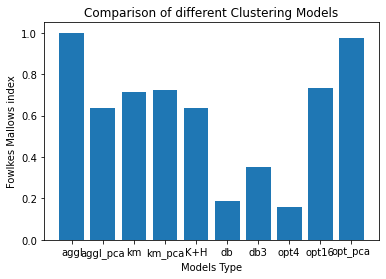

In [56]:
models = ['aggl', 'aggl_pca', 'km', 'km_pca', 'K+H', 'db', 'db3', 'opt4', 'opt16', 'opt_pca']

plt.bar(models,fms_scores)
plt.xlabel('Models Type')
plt.ylabel('Fowlkes Mallows index')
plt.title('Comparison of different Clustering Models')
plt.show()

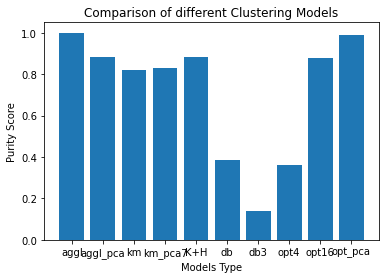

In [57]:
models = ['aggl', 'aggl_pca', 'km', 'km_pca7', 'K+H', 'db', 'db3', 'opt4', 'opt16', 'opt_pca']

plt.bar(models,purity_scores)
plt.xlabel('Models Type')
plt.ylabel('Purity Score')
plt.title('Comparison of different Clustering Models')
plt.show()

## Conclusion

As result the best algorithms that managed to cluster in a satisfactory way my data in the 8 classes are the hierarchical clustering (with distance 'chebyshev' and linkage 'average') and the OPTIC (with 25 min samples but with the use of data selected according to the first 7 PCs): the high scores I got from the two selected scoring methods highlights the clustering accuracy of this two models.
I also plotted the clusters obtained with this two methods and it's clear that the algorithm was capable of recreate the initial 8 classes starting from the selected features.

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


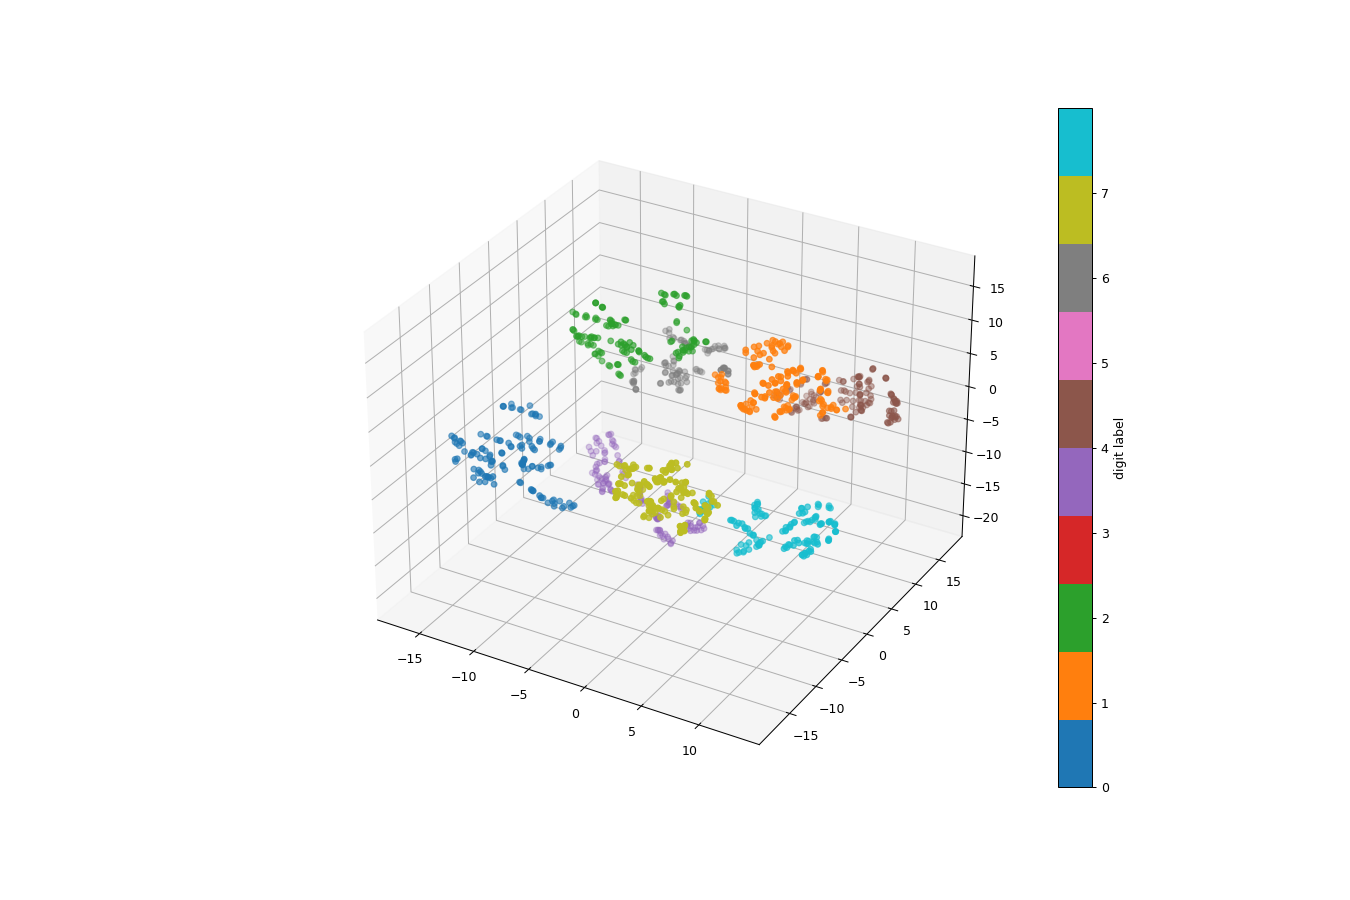

In [60]:
interactive_plot3d(X, labels=y_predict_agg_chb_avg)

C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


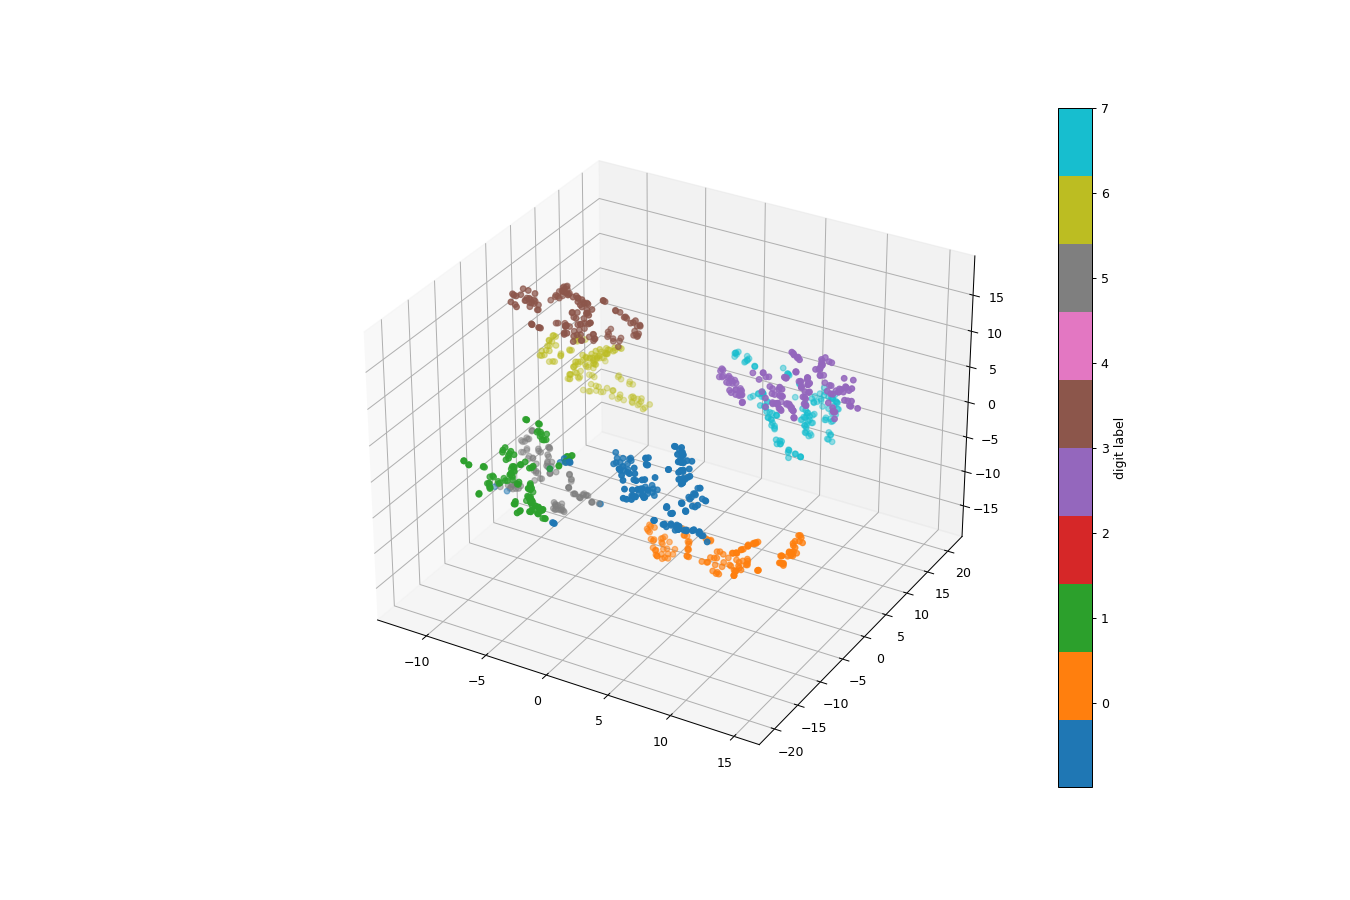

In [59]:
interactive_plot3d(X, labels=y_predict_opt_pca)